In [ ]:
!pip install adjustText
!pip install catboost
!pip install shap
import pandas as pd
import re
import warnings
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import shap  
from matplotlib.ticker import FuncFormatter
from adjustText import adjust_text
from textwrap import wrap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV,KFold,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from catboost import Pool, cv, CatBoostClassifier
from sklearn.metrics import  classification_report, log_loss, roc_auc_score

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

games = pd.read_csv("/content/drive/MyDrive/datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/games.csv")
details = pd.read_csv("/content/drive/MyDrive/datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/games_details.csv")
teams = pd.read_csv("/content/drive/MyDrive/datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/teams.csv")
players = pd.read_csv("/content/drive/MyDrive/datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/players.csv")
ranking = pd.read_csv("/content/drive/MyDrive/datasets/DATASET NBA/data complémentaires/KAGGLE Dataset with all NBA games from 2004 season to dec 2020/ranking.csv")

  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7094 sha256=369e72490e6d06b6e29f045594c6c56914aa0a0f77e4e06d107bff6e24e20848
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built adjustText
     |████████████████████████████████| 76.3 MB 50 kB/s 
     |████████████████████████████████| 371 kB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509240 sha256=2ea965d8ce927d452166eea20499cd510ac3a8c648d2f82b5724fe4aa64190b6
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [ ]:
pip install eli5

     |████████████████████████████████| 106 kB 5.4 MB/s 


In [ ]:
import eli5
from eli5.sklearn import PermutationImportance


The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


In [ ]:
# avant reformatage
games.describe()

,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
count,2.467700e+04,2.467700e+04,2.467700e+04,24677.000000,2.467700e+04,24578.000000,24578.000000,24578.000000,24578.000000,24578.000000,24578.000000,2.467700e+04,24578.000000,24578.000000,24578.00000,24578.000000,24578.000000,24578.000000,24677.000000
mean,2.164456e+07,1.610613e+09,1.610613e+09,2011.382826,1.610613e+09,102.766621,0.460256,0.759083,0.356084,22.649972,43.272764,1.610613e+09,99.907641,0.449023,0.75738,0.349443,21.296607,41.972821,0.589051
std,5.492537e+06,8.640971e+00,8.658197e+00,5.145644,8.640971e+00,13.112642,0.056706,0.100530,0.113140,5.169164,6.609140,8.658197e+00,13.247136,0.055554,0.10330,0.111319,5.126141,6.508188,0.492016
min,1.030000e+07,1.610613e+09,1.610613e+09,2003.000000,1.610613e+09,36.000000,0.250000,0.143000,0.000000,6.000000,15.000000,1.610613e+09,33.000000,0.244000,0.14300,0.000000,4.000000,19.000000,0.000000
25%,2.060088e+07,1.610613e+09,1.610613e+09,2007.000000,1.610613e+09,94.000000,0.421000,0.696000,0.286000,19.000000,39.000000,1.610613e+09,91.000000,0.411000,0.69200,0.278000,18.000000,38.000000,0.000000
50%,2.110090e+07,1.610613e+09,1.610613e+09,2011.000000,1.610613e+09,102.000000,0.459000,0.765000,0.357000,22.000000,43.000000,1.610613e+09,99.000000,0.448000,0.76200,0.350000,21.000000,42.000000,1.000000
75%,2.160116e+07,1.610613e+09,1.610613e+09,2016.000000,1.610613e+09,111.000000,0.500000,0.828000,0.429000,26.000000,48.000000,1.610613e+09,109.000000,0.487000,0.82800,0.421000,25.000000,46.000000,1.000000
max,5.200021e+07,1.610613e+09,1.610613e+09,2020.000000,1.610613e+09,168.000000,0.684000,1.000000,1.000000,50.000000,72.000000,1.610613e+09,168.000000,0.674000,1.00000,1.000000,46.000000,81.000000,1.000000


In [ ]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24677 entries, 0 to 24676
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GAME_DATE_EST     24677 non-null  object 
 1   GAME_ID           24677 non-null  int64  
 2   GAME_STATUS_TEXT  24677 non-null  object 
 3   HOME_TEAM_ID      24677 non-null  int64  
 4   VISITOR_TEAM_ID   24677 non-null  int64  
 5   SEASON            24677 non-null  int64  
 6   TEAM_ID_home      24677 non-null  int64  
 7   PTS_home          24578 non-null  float64
 8   FG_PCT_home       24578 non-null  float64
 9   FT_PCT_home       24578 non-null  float64
 10  FG3_PCT_home      24578 non-null  float64
 11  AST_home          24578 non-null  float64
 12  REB_home          24578 non-null  float64
 13  TEAM_ID_away      24677 non-null  int64  
 14  PTS_away          24578 non-null  float64
 15  FG_PCT_away       24578 non-null  float64
 16  FT_PCT_away       24578 non-null  float6

In [ ]:
# Avant reformatage
details.head(10)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,42000102,1610612764,WAS,Washington,203078,Bradley Beal,F,NaN,34:36,14.0,28.0,0.500,1.0,6.0,0.167,4.0,6.0,0.667,0.0,4.0,4.0,3.0,1.0,0.0,1.0,0.0,33.0,-22.0
1,42000102,1610612764,WAS,Washington,1629060,Rui Hachimura,F,NaN,25:50,4.0,6.0,0.667,1.0,1.0,1.000,2.0,3.0,0.667,2.0,5.0,7.0,1.0,0.0,0.0,3.0,4.0,11.0,-6.0
2,42000102,1610612764,WAS,Washington,203458,Alex Len,C,NaN,12:11,3.0,5.0,0.600,0.0,0.0,0.000,0.0,0.0,0.000,3.0,2.0,5.0,0.0,1.0,0.0,0.0,2.0,6.0,-11.0
3,42000102,1610612764,WAS,Washington,203526,Raul Neto,G,NaN,19:19,2.0,5.0,0.400,0.0,2.0,0.000,0.0,0.0,0.000,1.0,2.0,3.0,1.0,0.0,0.0,0.0,2.0,4.0,-17.0
4,42000102,1610612764,WAS,Washington,201566,Russell Westbrook,G,NaN,29:07,2.0,10.0,0.200,0.0,3.0,0.000,6.0,10.0,0.600,2.0,4.0,6.0,11.0,0.0,0.0,4.0,0.0,10.0,-16.0
5,42000102,1610612764,WAS,Washington,202722,Davis Bertans,NaN,NaN,23:43,0.0,4.0,0.000,0.0,4.0,0.000,0.0,0.0,0.000,0.0,2.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,-11.0
6,42000102,1610612764,WAS,Washington,202397,Ish Smith,NaN,NaN,23:20,5.0,14.0,0.357,0.0,2.0,0.000,0.0,0.0,0.000,0.0,1.0,1.0,3.0,0.0,0.0,1.0,1.0,10.0,-10.0
7,42000102,1610612764,WAS,Washington,1629655,Daniel Gafford,NaN,NaN,20:00,3.0,4.0,0.750,0.0,0.0,0.000,5.0,9.0,0.556,4.0,2.0,6.0,1.0,1.0,1.0,1.0,1.0,11.0,-1.0
8,42000102,1610612764,WAS,Washington,1628990,Chandler Hutchison,NaN,NaN,16:29,1.0,4.0,0.250,0.0,0.0,0.000,2.0,2.0,1.000,0.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,4.0,-17.0
9,42000102,1610612764,WAS,Washington,201577,Robin Lopez,NaN,NaN,10:15,2.0,3.0,0.667,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,-12.0


In [ ]:
details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615626 entries, 0 to 615625
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   GAME_ID            615626 non-null  int64  
 1   TEAM_ID            615626 non-null  int64  
 2   TEAM_ABBREVIATION  615626 non-null  object 
 3   TEAM_CITY          615626 non-null  object 
 4   PLAYER_ID          615626 non-null  int64  
 5   PLAYER_NAME        615626 non-null  object 
 6   START_POSITION     235795 non-null  object 
 7   COMMENT            100048 non-null  object 
 8   MIN                515577 non-null  object 
 9   FGM                515577 non-null  float64
 10  FGA                515577 non-null  float64
 11  FG_PCT             515577 non-null  float64
 12  FG3M               515577 non-null  float64
 13  FG3A               515577 non-null  float64
 14  FG3_PCT            515577 non-null  float64
 15  FTM                515577 non-null  float64
 16  FT

In [ ]:
teams.head(1)

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612737,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks


In [ ]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LEAGUE_ID           30 non-null     int64  
 1   TEAM_ID             30 non-null     int64  
 2   MIN_YEAR            30 non-null     int64  
 3   MAX_YEAR            30 non-null     int64  
 4   ABBREVIATION        30 non-null     object 
 5   NICKNAME            30 non-null     object 
 6   YEARFOUNDED         30 non-null     int64  
 7   CITY                30 non-null     object 
 8   ARENA               30 non-null     object 
 9   ARENACAPACITY       26 non-null     float64
 10  OWNER               30 non-null     object 
 11  GENERALMANAGER      30 non-null     object 
 12  HEADCOACH           30 non-null     object 
 13  DLEAGUEAFFILIATION  30 non-null     object 
dtypes: float64(1), int64(5), object(8)
memory usage: 3.4+ KB


In [ ]:
players.head(1)

,PLAYER_NAME,TEAM_ID,PLAYER_ID,SEASON
0,Royce O'Neale,1610612762,1626220,2019


In [ ]:
players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7228 entries, 0 to 7227
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PLAYER_NAME  7228 non-null   object
 1   TEAM_ID      7228 non-null   int64 
 2   PLAYER_ID    7228 non-null   int64 
 3   SEASON       7228 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 226.0+ KB


In [ ]:
ranking.head(1)

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
0,1610612762,0,22020,2021-05-26,West,Utah,72,52,20,0.722,31-5,21-15,NaN


In [ ]:
ranking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193092 entries, 0 to 193091
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TEAM_ID        193092 non-null  int64  
 1   LEAGUE_ID      193092 non-null  int64  
 2   SEASON_ID      193092 non-null  int64  
 3   STANDINGSDATE  193092 non-null  object 
 4   CONFERENCE     193092 non-null  object 
 5   TEAM           193092 non-null  object 
 6   G              193092 non-null  int64  
 7   W              193092 non-null  int64  
 8   L              193092 non-null  int64  
 9   W_PCT          193092 non-null  float64
 10  HOME_RECORD    193092 non-null  object 
 11  ROAD_RECORD    193092 non-null  object 
 12  RETURNTOPLAY   3990 non-null    float64
dtypes: float64(2), int64(6), object(5)
memory usage: 19.2+ MB


In [ ]:
# Reformatage Player NAME
details['PLAYER_NAME_SHORT'] = details['PLAYER_NAME'].str.replace('^(.).*\s(.*)', '\\1.\\2')   #     .* <=> followed by 0 or more (any) characters       ^<=> starts with 

# Reformatage Colonne  MIN
details[["MINS", "SECS"]] = details.MIN.str.extract(r"([^:]+):(.*)")
details.loc[(~details.MIN.str.contains(':', na = True)), 'SECS'] = details.MIN
details.MINS = pd.to_numeric(details.MINS)
details.SECS = pd.to_numeric(details.SECS)
details['PLAY_TIME'] = np.round(details.MINS.fillna(0) + details.SECS/60)

In [ ]:
# Apres reformatage
details.head(10)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,PLAYER_NAME_SHORT,MINS,SECS,PLAY_TIME
0,42000102,1610612764,WAS,Washington,203078,Bradley Beal,F,NaN,34:36,14.0,28.0,0.500,1.0,6.0,0.167,4.0,6.0,0.667,0.0,4.0,4.0,3.0,1.0,0.0,1.0,0.0,33.0,-22.0,B.Beal,34.0,36.0,35.0
1,42000102,1610612764,WAS,Washington,1629060,Rui Hachimura,F,NaN,25:50,4.0,6.0,0.667,1.0,1.0,1.000,2.0,3.0,0.667,2.0,5.0,7.0,1.0,0.0,0.0,3.0,4.0,11.0,-6.0,R.Hachimura,25.0,50.0,26.0
2,42000102,1610612764,WAS,Washington,203458,Alex Len,C,NaN,12:11,3.0,5.0,0.600,0.0,0.0,0.000,0.0,0.0,0.000,3.0,2.0,5.0,0.0,1.0,0.0,0.0,2.0,6.0,-11.0,A.Len,12.0,11.0,12.0
3,42000102,1610612764,WAS,Washington,203526,Raul Neto,G,NaN,19:19,2.0,5.0,0.400,0.0,2.0,0.000,0.0,0.0,0.000,1.0,2.0,3.0,1.0,0.0,0.0,0.0,2.0,4.0,-17.0,R.Neto,19.0,19.0,19.0
4,42000102,1610612764,WAS,Washington,201566,Russell Westbrook,G,NaN,29:07,2.0,10.0,0.200,0.0,3.0,0.000,6.0,10.0,0.600,2.0,4.0,6.0,11.0,0.0,0.0,4.0,0.0,10.0,-16.0,R.Westbrook,29.0,7.0,29.0
5,42000102,1610612764,WAS,Washington,202722,Davis Bertans,NaN,NaN,23:43,0.0,4.0,0.000,0.0,4.0,0.000,0.0,0.0,0.000,0.0,2.0,2.0,0.0,0.0,0.0,0.0,6.0,0.0,-11.0,D.Bertans,23.0,43.0,24.0
6,42000102,1610612764,WAS,Washington,202397,Ish Smith,NaN,NaN,23:20,5.0,14.0,0.357,0.0,2.0,0.000,0.0,0.0,0.000,0.0,1.0,1.0,3.0,0.0,0.0,1.0,1.0,10.0,-10.0,I.Smith,23.0,20.0,23.0
7,42000102,1610612764,WAS,Washington,1629655,Daniel Gafford,NaN,NaN,20:00,3.0,4.0,0.750,0.0,0.0,0.000,5.0,9.0,0.556,4.0,2.0,6.0,1.0,1.0,1.0,1.0,1.0,11.0,-1.0,D.Gafford,20.0,0.0,20.0
8,42000102,1610612764,WAS,Washington,1628990,Chandler Hutchison,NaN,NaN,16:29,1.0,4.0,0.250,0.0,0.0,0.000,2.0,2.0,1.000,0.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,4.0,-17.0,C.Hutchison,16.0,29.0,16.0
9,42000102,1610612764,WAS,Washington,201577,Robin Lopez,NaN,NaN,10:15,2.0,3.0,0.667,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,-12.0,R.Lopez,10.0,15.0,10.0


In [ ]:
games = games.loc[~games[['GAME_ID', 'GAME_DATE_EST']].duplicated()] #Leaving one entry per game
games['GAME_DATE_EST'] = pd.to_datetime(games.GAME_DATE_EST)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# après reformatage
games.describe()

,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
count,2.462200e+04,2.462200e+04,2.462200e+04,24622.000000,2.462200e+04,24523.000000,24523.000000,24523.000000,24523.000000,24523.000000,24523.000000,2.462200e+04,24523.000000,24523.000000,24523.000000,24523.000000,24523.000000,24523.000000,24622.000000
mean,2.164376e+07,1.610613e+09,1.610613e+09,2011.363577,1.610613e+09,102.748644,0.460267,0.759121,0.356100,22.645394,43.265995,1.610613e+09,99.885251,0.449007,0.757358,0.349423,21.290992,41.968030,0.589026
std,5.498642e+06,8.641064e+00,8.657190e+00,5.135226,8.641064e+00,13.106909,0.056719,0.100510,0.113178,5.168242,6.608594,8.657190e+00,13.240991,0.055567,0.103231,0.111354,5.126209,6.509393,0.492021
min,1.030000e+07,1.610613e+09,1.610613e+09,2003.000000,1.610613e+09,36.000000,0.250000,0.143000,0.000000,6.000000,15.000000,1.610613e+09,33.000000,0.244000,0.143000,0.000000,4.000000,19.000000,0.000000
25%,2.060086e+07,1.610613e+09,1.610613e+09,2007.000000,1.610613e+09,94.000000,0.421000,0.696000,0.286000,19.000000,39.000000,1.610613e+09,91.000000,0.411000,0.692000,0.278000,18.000000,37.000000,0.000000
50%,2.110087e+07,1.610613e+09,1.610613e+09,2011.000000,1.610613e+09,102.000000,0.459000,0.765000,0.357000,22.000000,43.000000,1.610613e+09,99.000000,0.448000,0.762000,0.350000,21.000000,42.000000,1.000000
75%,2.160112e+07,1.610613e+09,1.610613e+09,2016.000000,1.610613e+09,111.000000,0.500000,0.828000,0.429000,26.000000,48.000000,1.610613e+09,109.000000,0.487000,0.828000,0.421000,25.000000,46.000000,1.000000
max,5.200021e+07,1.610613e+09,1.610613e+09,2020.000000,1.610613e+09,168.000000,0.684000,1.000000,1.000000,50.000000,72.000000,1.610613e+09,168.000000,0.674000,1.000000,1.000000,46.000000,81.000000,1.000000


In [ ]:
def get_season(date): ###
    '''
    Returns the season based on the month and year of a date
    '''
    date = pd.to_datetime(date, format='%Y-%m-%d')
    if (date.month >= 10):
        season = date.year
    else:
        season = date.year - 1
    return season

def get_season_data(season):
    ''' 
    Aggregates the details data into yearly figures
    Returns the aggregated data and the standardised aggregated data    
    '''
    # Création nouvelles tables à partir de la table details
    temp = details.loc[details.GAME_ID.isin(games.loc[games.SEASON == season, 'GAME_ID'])]
    temp = temp.loc[~temp['PLAY_TIME'].isnull()]
    agg_df = temp.groupby(['PLAYER_ID', 'PLAYER_NAME', 'PLAYER_NAME_SHORT'])[['FGA', 'FGM', 'FG3A', 'FG3M', 'FTA', 'FTM', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PLAY_TIME']].sum().reset_index()
    agg_df = agg_df.loc[agg_df['PLAY_TIME'] >= 1200].reset_index(drop = True) #### choix arbitraire de 1200min
    st_agg_df = StandardScaler().fit_transform(agg_df.drop(columns = ['PLAYER_ID', 'PLAYER_NAME', 'PLAY_TIME', 'PLAYER_NAME_SHORT']))
    return(agg_df, st_agg_df)

In [ ]:
#Création table temporaire -> temp (jointure interne 'isin' de la table games avec la clé GAME_ID)
#                 					-> temp : retrait des valeurs nulles de PLAY_TIME

temp = details.loc[details.GAME_ID.isin(games.loc[games.SEASON == 2020, 'GAME_ID'])]
temp = temp.loc[~temp['PLAY_TIME'].isnull()]

# Agrége les données de la table details en chiffres annuels  -> agg_df
# Renvoie les données agrégées et les données agrégées standardisées  -> st_agg_df
# agg_df (données annuelles, ici 2020)
agg_df = temp.groupby(['PLAYER_ID', 'PLAYER_NAME', 'PLAYER_NAME_SHORT'])[['FGA', 'FGM', 'FG3A', 'FG3M', 'FTA', 'FTM', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'TO', 'PF', 'PLAY_TIME']].sum().reset_index()
agg_df = agg_df.loc[agg_df['PLAY_TIME'] >= 1200].reset_index(drop = True) #### choix arbitraire du temps de jeu annuel en minutes
st_agg_df = StandardScaler().fit_transform(agg_df.drop(columns = ['PLAYER_ID', 'PLAYER_NAME', 'PLAY_TIME', 'PLAYER_NAME_SHORT']))

In [ ]:
agg_df.head(500)

,PLAYER_ID,PLAYER_NAME,PLAYER_NAME_SHORT,FGA,FGM,FG3A,FG3M,FTA,FTM,OREB,DREB,AST,STL,BLK,TO,PF,PLAY_TIME
0,2544,LeBron James,L.James,930.0,472.0,322.0,120.0,298.0,204.0,38.0,350.0,398.0,58.0,27.0,192.0,82.0,1712.0
1,2546,Carmelo Anthony,C.Anthony,847.0,355.0,349.0,144.0,172.0,153.0,35.0,198.0,108.0,50.0,40.0,71.0,160.0,1827.0
2,2730,Dwight Howard,D.Howard,321.0,190.0,20.0,5.0,226.0,127.0,201.0,403.0,63.0,32.0,63.0,119.0,214.0,1258.0
3,2738,Andre Iguodala,A.Iguodala,258.0,99.0,186.0,61.0,38.0,25.0,42.0,192.0,147.0,60.0,35.0,71.0,99.0,1395.0
4,101108,Chris Paul,C.Paul,933.0,458.0,270.0,105.0,195.0,180.0,28.0,310.0,666.0,105.0,21.0,170.0,182.0,2362.0
5,101150,Lou Williams,L.Williams,685.0,288.0,182.0,75.0,183.0,158.0,21.0,121.0,233.0,49.0,6.0,116.0,67.0,1497.0
6,200752,Rudy Gay,R.Gay,684.0,289.0,301.0,114.0,115.0,90.0,47.0,283.0,96.0,49.0,41.0,73.0,122.0,1487.0
7,200768,Kyle Lowry,K.Lowry,625.0,273.0,347.0,139.0,168.0,147.0,35.0,212.0,351.0,49.0,14.0,129.0,153.0,1666.0
8,200782,P.J. Tucker,P.Tucker,186.0,71.0,128.0,45.0,30.0,23.0,53.0,160.0,64.0,39.0,20.0,40.0,136.0,1436.0
9,200794,Paul Millsap,P.Millsap,453.0,219.0,163.0,57.0,119.0,90.0,80.0,212.0,110.0,60.0,38.0,59.0,121.0,1279.0


In [ ]:
# agg_df.describe().iloc[0,0] # 584 joueurs
# agg_df = agg_df.loc[agg_df['PLAY_TIME'] >= 1500].reset_index(drop = True)
# agg_df.describe().iloc[0,0] # 156 joueurs

In [ ]:
# MACHINE LEARNING NON SUPERVISE -> PCA
pca = PCA(n_components = 3)
agg_df, st_agg_df = get_season_data(2020) ###
pcomp = pca.fit_transform(st_agg_df) # PCA sur données standardisées
df = pd.DataFrame(pca.components_, 
             index = ['PC 1', 'PC 2','PC 3'],
             columns = agg_df.drop(columns = ['PLAYER_ID', 'PLAYER_NAME', 'PLAY_TIME', 'PLAYER_NAME_SHORT']).columns).round(2)
styles = [dict(selector="caption", props=[("caption-side", "bottom")])]
df.style.set_table_styles(styles).set_properties(**{'font-size':'8pt'}).background_gradient('Greens').set_precision(2).set_caption('Breakdown of the principal components for the 2020 season')

,FGA,FGM,FG3A,FG3M,FTA,FTM,OREB,DREB,AST,STL,BLK,TO,PF
PC 1,0.39,0.39,0.19,0.18,0.36,0.37,0.05,0.23,0.31,0.20,0.02,0.38,0.15
PC 2,-0.10,0.01,-0.41,-0.41,0.11,0.05,0.50,0.35,-0.09,-0.04,0.42,0.03,0.28
PC 3,-0.14,-0.12,-0.42,-0.45,0.14,0.13,-0.12,-0.22,0.43,0.29,-0.29,0.20,-0.30


In [ ]:
pca = PCA(n_components = 2)
agg_df, st_agg_df = get_season_data(2020)
pcomp = pca.fit_transform(st_agg_df)
df = pd.DataFrame(pca.components_, 
             index = ['PC 1', 'PC 2'],
             columns = agg_df.drop(columns = ['PLAYER_ID', 'PLAYER_NAME', 'PLAY_TIME', 'PLAYER_NAME_SHORT']).columns).round(2)
styles = [dict(selector="caption", props=[("caption-side", "bottom")])]
df.style.set_table_styles(styles).set_properties(**{'font-size':'8pt'}).background_gradient('Greens').set_precision(2).set_caption('Breakdown of the principal components for the 2020 season')

,FGA,FGM,FG3A,FG3M,FTA,FTM,OREB,DREB,AST,STL,BLK,TO,PF
PC 1,0.39,0.39,0.19,0.18,0.36,0.37,0.05,0.23,0.31,0.20,0.02,0.38,0.15
PC 2,-0.10,0.01,-0.41,-0.41,0.11,0.05,0.50,0.35,-0.09,-0.04,0.42,0.03,0.28


In [ ]:
def pca_plots(season, ax = None):
    '''
    Performs PCA on season data
    Calculates the top players based on the 2 PCs
    Creates a scatter plot for visualising the season data
    '''
    
    #pca = PCA(n_components = 3)
    pca = PCA(n_components = 2)
    agg_df, st_agg_df = get_season_data(season)
    pcomp = pca.fit_transform(st_agg_df)
    
    overall = pcomp.sum(axis = 1)
    top_overall = np.argpartition(overall, -4)[-4:]
    top_pc1 = np.argpartition(pcomp[:,0], -4)[-4:]
    top_pc2 = np.argpartition(pcomp[:,1], -4)[-4:]
    # top_pc3 = np.argpartition(pcomp[:,2], -4)[-4:]
    # top_pc = list(set(list(top_pc1) + list(top_pc2) + list(top_pc3) + list(top_overall)))
    top_pc = list(set(list(top_pc1) + list(top_pc2) + list(top_overall)))

    ##alphas = np.zeros(pcomp.shape[0]) + 0.3
    ##alphas[top_pc] = 1
    
    # ax.scatter(pcomp[:, 0], pcomp[:, 1], pcomp[:, 2], alpha = alphas)
    ax.scatter(pcomp[:, 0], pcomp[:, 1])##, alpha = alphas)
    ax.axhline(y = 0, color ='green', linestyle='--', lw=1)
    ax.axvline(x = 0, color ='green', linestyle='--', lw=1)
    #texts = [ax.text(x=pcomp[i, 0],y=pcomp[i, 1], z=pcomp[i, 2],s=agg_df.PLAYER_NAME_SHORT[i]) for i in top_pc]
    texts = [ax.text(x=pcomp[i, 0],y=pcomp[i, 1],s=agg_df.PLAYER_NAME_SHORT[i]) for i in top_pc]
    adjust_text(texts, ax = ax, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
    _ = ax.set_title(str(season))

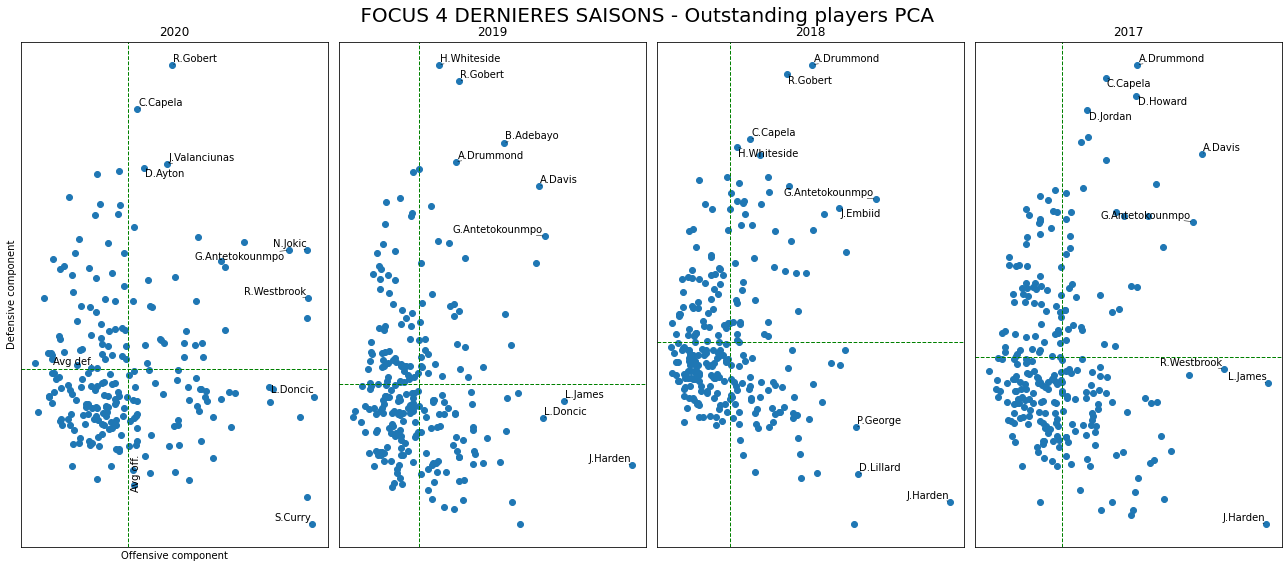

In [ ]:
# FOCUS SUR LES 4 DERNIERES SAISONS

fig,axes = plt.subplots(1, 4, figsize=(18,8))
for i,season in enumerate(range(games.SEASON.max(), games.SEASON.min()+13, -1)):
    pca_plots(season, ax = axes.ravel()[i])    
    axes.ravel()[i].tick_params(bottom=False, left=False, labelbottom = False, labelleft = False)
    if (i % 5 == 0 ):
        axes.ravel()[i].set_xlabel('Offensive component')
        axes.ravel()[i].set_ylabel('Defensive component')
        axes.ravel()[i].text(x = 0.1, y = -3, s = 'Avg off.',rotation=90)
        axes.ravel()[i].text(x = -3, y = 0.1, s = 'Avg def.')
fig.suptitle(' FOCUS 4 DERNIERES SAISONS - Outstanding players PCA', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

In [ ]:
# pca a 3 composantes principales
def pca_plots2(season, ax = None):
    '''
    Performs PCA on season data
    Calculates the top players based on the 2 PCs
    Creates a scatter plot for visualising the season data
    '''
    
    pca = PCA(n_components = 3)
    #pca = PCA(n_components = 2)
    agg_df, st_agg_df = get_season_data(season)
    pcomp = pca.fit_transform(st_agg_df)
    
    overall = pcomp.sum(axis = 1)
    top_overall = np.argpartition(overall, -4)[-4:]
    top_pc1 = np.argpartition(pcomp[:,0], -4)[-4:]
    top_pc2 = np.argpartition(pcomp[:,1], -4)[-4:]
    top_pc3 = np.argpartition(pcomp[:,2], -4)[-4:]
    top_pc = list(set(list(top_pc1) + list(top_pc2) + list(top_pc3) + list(top_overall)))
    #top_pc = list(set(list(top_pc1) + list(top_pc2) + list(top_overall)))

    ##alphas = np.zeros(pcomp.shape[0]) + 0.3
    ##alphas[top_pc] = 1
    
    ax.scatter(pcomp[:, 0], pcomp[:, 1], pcomp[:, 2], alpha = alphas)
    #ax.scatter(pcomp[:, 0], pcomp[:, 1])##, alpha = alphas)
    ax.axhline(y = 0, color ='green', linestyle='--', lw=1)
    ax.axvline(x = 0, color ='green', linestyle='--', lw=1)
    texts = [ax.text(x=pcomp[i, 0],y=pcomp[i, 1], z=pcomp[i, 2],s=agg_df.PLAYER_NAME_SHORT[i]) for i in top_pc]
    #texts = [ax.text(x=pcomp[i, 0],y=pcomp[i, 1],s=agg_df.PLAYER_NAME_SHORT[i]) for i in top_pc]
    adjust_text(texts, ax = ax, arrowprops=dict(arrowstyle="-", color='k', lw=0.5))
    _ = ax.set_title(str(season))

In [ ]:
#fig,axes = plt.subplots(4, 4, figsize=(15,15))
#for i,season in enumerate(range(games.SEASON.max(), games.SEASON.min()+1, -1)):
#    pca_plots(season, ax = axes.ravel()[i])    
#    axes.ravel()[i].tick_params(bottom=False, left=False, labelbottom = False, labelleft = False)
#    if (i % 5 == 0 ):
#        axes.ravel()[i].set_xlabel('Offensive component')
#        axes.ravel()[i].set_ylabel('Defensive component')
#        #axes.ravel()[i].set_zlabel('Aggressive component')
#        axes.ravel()[i].text(x = 0.1, y = -3, s = 'Avg off.',rotation=90)
#        axes.ravel()[i].text(x = -3, y = 0.1, s = 'Avg def.')
#fig.suptitle('Outstanding players by principal components per season', fontsize = 20)
#fig.tight_layout()
#fig.subplots_adjust(top=0.92)
#plt.show()

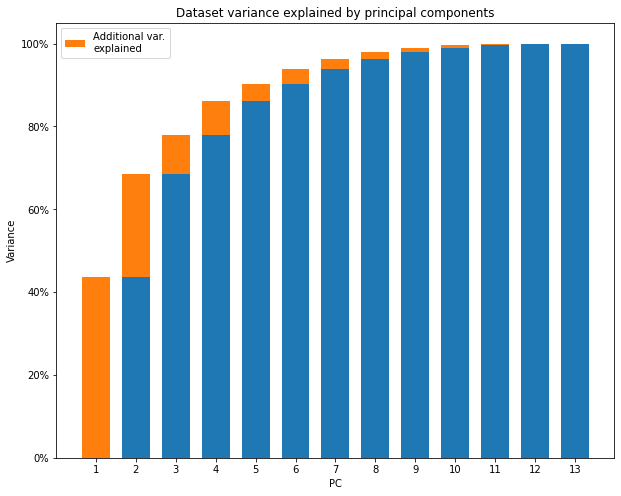

In [ ]:
# explication de la variance vs nb de composantes principales

pca_all = PCA()
pca_all.fit(st_agg_df)
cum_var = np.cumsum(pca_all.explained_variance_ratio_)
cum_var = np.insert(cum_var, 0, 0)
cum_var = cum_var[:-1]

comp = [str(x + 1) for x in range(pca_all.n_components_)]
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(comp, cum_var, align='center', width=0.7, label='_nolegend_')
ax.bar(comp, pca_all.explained_variance_ratio_, bottom=cum_var, align='center', width=0.7, label= '\n'.join(wrap('Additional var. explained', 20)))
ax.set_ylabel('Variance')
ax.yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format))
ax.set_xlabel('PC')
ax.set_title('Dataset variance explained by principal components')
ax.legend()
plt.show()

## **Preparation of modelling**

In [ ]:
ranking['STANDINGSDATE'] = pd.to_datetime(ranking['STANDINGSDATE'])
ranking.sort_values('STANDINGSDATE', inplace = True)
ranking.head()
#ranking = ranking.loc[ranking.SEASON_ID // 10000 == 2]
#ranking['SEASON_ID'] = ranking['SEASON_ID'] % 10000
#ranking['MAX_S_GAMES'] = ranking.groupby('SEASON_ID').G.transform(max)

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
164300,1610612752,0,22002,2003-10-01,East,New York,82,37,45,0.451,24-17,13-28,NaN
164292,1610612765,0,22002,2003-10-01,East,Detroit,82,50,32,0.610,30-11,20-21,NaN
164293,1610612751,0,22002,2003-10-01,East,New Jersey,82,49,33,0.598,33-8,16-25,NaN
164294,1610612754,0,22002,2003-10-01,East,Indiana,82,48,34,0.585,32-9,16-25,NaN
164295,1610612755,0,22002,2003-10-01,East,Philadelphia,82,48,34,0.585,25-16,23-18,NaN


In [ ]:
ranking = ranking.loc[ranking.SEASON_ID // 10000 == 2]
ranking['SEASON_ID'] = ranking['SEASON_ID'] % 10000
ranking.head(1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
164300,1610612752,0,2002,2003-10-01,East,New York,82,37,45,0.451,24-17,13-28,NaN


In [ ]:
ranking['MAX_S_GAMES'] = ranking.groupby('SEASON_ID').G.transform(max)
ranking.head(1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY,MAX_S_GAMES
164300,1610612752,0,2002,2003-10-01,East,New York,82,37,45,0.451,24-17,13-28,NaN,82


In [ ]:
# Creating a df with season start and end for excluding preseason and playoff games
start_dates = ranking.loc[ranking.SEASON_ID > 2002].groupby('SEASON_ID')['STANDINGSDATE'].min().to_frame('FIRST_GAME').reset_index()
start_dates.head(1)

,SEASON_ID,FIRST_GAME
0,2003,2003-10-28


In [ ]:
t = ranking.loc[(ranking['G'] == ranking['MAX_S_GAMES'])].groupby(['SEASON_ID', 'STANDINGSDATE'])['TEAM_ID'].nunique().to_frame('TEAMS').reset_index()
t.tail(10) # nb équipes engagées par saisons

,SEASON_ID,STANDINGSDATE,TEAMS
2951,2020,2021-05-17,30
2952,2020,2021-05-18,30
2953,2020,2021-05-19,30
2954,2020,2021-05-20,30
2955,2020,2021-05-21,30
2956,2020,2021-05-22,30
2957,2020,2021-05-23,30
2958,2020,2021-05-24,30
2959,2020,2021-05-25,30
2960,2020,2021-05-26,30


In [ ]:
playoff_dates = t.loc[(t.TEAMS == 30) | ((t.TEAMS == 28) & (t.SEASON_ID == 2012)) | ((t.TEAMS == 29) & (t.SEASON_ID == 2003))].groupby('SEASON_ID')['STANDINGSDATE'].min().to_frame('LAST_GAME').reset_index()
playoff_dates.tail(5)

,SEASON_ID,LAST_GAME
12,2015,2016-04-13
13,2016,2017-04-12
14,2017,2018-04-11
15,2018,2019-04-10
16,2020,2021-05-16


In [ ]:
dates = start_dates.merge(playoff_dates, how = 'left')
dates.loc[dates.SEASON_ID == 2019, 'LAST_GAME'] = pd.to_datetime('2020-03-12') #Manually adding the end of regular season

In [ ]:
dates.head(1)

,SEASON_ID,FIRST_GAME,LAST_GAME
0,2003,2003-10-28,2004-04-14


In [ ]:
# Filtering out details for non-regular season games
details = details.merge(games[['GAME_ID', 'GAME_DATE_EST', 'SEASON']], how = 'left')
details.head(1)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,PLAYER_NAME_SHORT,MINS,SECS,PLAY_TIME,GAME_DATE_EST,SEASON
0,42000102,1610612764,WAS,Washington,203078,Bradley Beal,F,NaN,34:36,14.0,28.0,0.5,1.0,6.0,0.167,4.0,6.0,0.667,0.0,4.0,4.0,3.0,1.0,0.0,1.0,0.0,33.0,-22.0,B.Beal,34.0,36.0,35.0,2021-05-26,2020


In [ ]:
details.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 615626 entries, 0 to 615625
Data columns (total 34 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   GAME_ID            615626 non-null  int64         
 1   TEAM_ID            615626 non-null  int64         
 2   TEAM_ABBREVIATION  615626 non-null  object        
 3   TEAM_CITY          615626 non-null  object        
 4   PLAYER_ID          615626 non-null  int64         
 5   PLAYER_NAME        615626 non-null  object        
 6   START_POSITION     235795 non-null  object        
 7   COMMENT            100048 non-null  object        
 8   MIN                515577 non-null  object        
 9   FGM                515577 non-null  float64       
 10  FGA                515577 non-null  float64       
 11  FG_PCT             515577 non-null  float64       
 12  FG3M               515577 non-null  float64       
 13  FG3A               515577 non-null  float64 

In [ ]:
details = details.merge(dates, left_on = 'SEASON', right_on = 'SEASON_ID', how = 'left')
details.head(1)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,PLAYER_NAME_SHORT,MINS,SECS,PLAY_TIME,GAME_DATE_EST,SEASON,SEASON_ID,FIRST_GAME,LAST_GAME
0,42000102,1610612764,WAS,Washington,203078,Bradley Beal,F,NaN,34:36,14.0,28.0,0.5,1.0,6.0,0.167,4.0,6.0,0.667,0.0,4.0,4.0,3.0,1.0,0.0,1.0,0.0,33.0,-22.0,B.Beal,34.0,36.0,35.0,2021-05-26,2020,2020,2020-12-22,2021-05-16


In [ ]:
details.info(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 615626 entries, 0 to 615625
Data columns (total 37 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   GAME_ID            615626 non-null  int64         
 1   TEAM_ID            615626 non-null  int64         
 2   TEAM_ABBREVIATION  615626 non-null  object        
 3   TEAM_CITY          615626 non-null  object        
 4   PLAYER_ID          615626 non-null  int64         
 5   PLAYER_NAME        615626 non-null  object        
 6   START_POSITION     235795 non-null  object        
 7   COMMENT            100048 non-null  object        
 8   MIN                515577 non-null  object        
 9   FGM                515577 non-null  float64       
 10  FGA                515577 non-null  float64       
 11  FG_PCT             515577 non-null  float64       
 12  FG3M               515577 non-null  float64       
 13  FG3A               515577 non-null  float64 

In [ ]:
details = details.loc[(details.LAST_GAME.isnull()) | ((details.GAME_DATE_EST <= details.LAST_GAME) & (details.GAME_DATE_EST > details.FIRST_GAME))]

#details = details.loc[(details.GAME_DATE_EST <= details.LAST_GAME) & (details.GAME_DATE_EST > details.FIRST_GAME)]

details.head(1)

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,START_POSITION,COMMENT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS,PLAYER_NAME_SHORT,MINS,SECS,PLAY_TIME,GAME_DATE_EST,SEASON,SEASON_ID,FIRST_GAME,LAST_GAME
645,22001073,1610612738,BOS,Boston,1628400,Semi Ojeleye,F,NaN,16:18,2.0,6.0,0.333,1.0,5.0,0.2,0.0,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,1.0,1.0,5.0,-10.0,S.Ojeleye,16.0,18.0,16.0,2021-05-16,2020,2020,2020-12-22,2021-05-16


In [ ]:
details.info(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531195 entries, 645 to 612892
Data columns (total 37 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   GAME_ID            531195 non-null  int64         
 1   TEAM_ID            531195 non-null  int64         
 2   TEAM_ABBREVIATION  531195 non-null  object        
 3   TEAM_CITY          531195 non-null  object        
 4   PLAYER_ID          531195 non-null  int64         
 5   PLAYER_NAME        531195 non-null  object        
 6   START_POSITION     214096 non-null  object        
 7   COMMENT            87674 non-null   object        
 8   MIN                443521 non-null  object        
 9   FGM                443521 non-null  float64       
 10  FGA                443521 non-null  float64       
 11  FG_PCT             443521 non-null  float64       
 12  FG3M               443521 non-null  float64       
 13  FG3A               443521 non-null  float6

In [ ]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24622 entries, 0 to 24676
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   GAME_DATE_EST     24622 non-null  datetime64[ns]
 1   GAME_ID           24622 non-null  int64         
 2   GAME_STATUS_TEXT  24622 non-null  object        
 3   HOME_TEAM_ID      24622 non-null  int64         
 4   VISITOR_TEAM_ID   24622 non-null  int64         
 5   SEASON            24622 non-null  int64         
 6   TEAM_ID_home      24622 non-null  int64         
 7   PTS_home          24523 non-null  float64       
 8   FG_PCT_home       24523 non-null  float64       
 9   FT_PCT_home       24523 non-null  float64       
 10  FG3_PCT_home      24523 non-null  float64       
 11  AST_home          24523 non-null  float64       
 12  REB_home          24523 non-null  float64       
 13  TEAM_ID_away      24622 non-null  int64         
 14  PTS_away          2452

In [ ]:
# Filtering out games for non-regular season games
games = games.merge(dates, left_on = 'SEASON', right_on = 'SEASON_ID', how = 'inner')


In [ ]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24622 entries, 0 to 24621
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   GAME_DATE_EST     24622 non-null  datetime64[ns]
 1   GAME_ID           24622 non-null  int64         
 2   GAME_STATUS_TEXT  24622 non-null  object        
 3   HOME_TEAM_ID      24622 non-null  int64         
 4   VISITOR_TEAM_ID   24622 non-null  int64         
 5   SEASON            24622 non-null  int64         
 6   TEAM_ID_home      24622 non-null  int64         
 7   PTS_home          24523 non-null  float64       
 8   FG_PCT_home       24523 non-null  float64       
 9   FT_PCT_home       24523 non-null  float64       
 10  FG3_PCT_home      24523 non-null  float64       
 11  AST_home          24523 non-null  float64       
 12  REB_home          24523 non-null  float64       
 13  TEAM_ID_away      24622 non-null  int64         
 14  PTS_away          2452

In [ ]:
games = games.loc[games.LAST_GAME.isnull() | ((games.GAME_DATE_EST <= games.LAST_GAME) & (games.GAME_DATE_EST > games.FIRST_GAME))]
games.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME'], inplace=True)

In [ ]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21396 entries, 22 to 24511
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   GAME_DATE_EST     21396 non-null  datetime64[ns]
 1   GAME_ID           21396 non-null  int64         
 2   GAME_STATUS_TEXT  21396 non-null  object        
 3   HOME_TEAM_ID      21396 non-null  int64         
 4   VISITOR_TEAM_ID   21396 non-null  int64         
 5   SEASON            21396 non-null  int64         
 6   TEAM_ID_home      21396 non-null  int64         
 7   PTS_home          21396 non-null  float64       
 8   FG_PCT_home       21396 non-null  float64       
 9   FT_PCT_home       21396 non-null  float64       
 10  FG3_PCT_home      21396 non-null  float64       
 11  AST_home          21396 non-null  float64       
 12  REB_home          21396 non-null  float64       
 13  TEAM_ID_away      21396 non-null  int64         
 14  PTS_away          213

In [ ]:
###########IMPORTANT // possibilité
# Excluding the 2020 season as it was plagued by Covid related results
#details = details.loc[details.SEASON != 2020]
#games = games.loc[games.SEASON != 2020]
#dates = dates.loc[dates.SEASON_ID != 2020]

In [ ]:
ranking.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181259 entries, 164300 to 0
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   TEAM_ID        181259 non-null  int64         
 1   LEAGUE_ID      181259 non-null  int64         
 2   SEASON_ID      181259 non-null  int64         
 3   STANDINGSDATE  181259 non-null  datetime64[ns]
 4   CONFERENCE     181259 non-null  object        
 5   TEAM           181259 non-null  object        
 6   G              181259 non-null  int64         
 7   W              181259 non-null  int64         
 8   L              181259 non-null  int64         
 9   W_PCT          181259 non-null  float64       
 10  HOME_RECORD    181259 non-null  object        
 11  ROAD_RECORD    181259 non-null  object        
 12  RETURNTOPLAY   3990 non-null    float64       
 13  MAX_S_GAMES    181259 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(7), object(4

In [ ]:
# Creating a new ranking df with regular season only and values that can be used for modeling 
ranking_short = ranking[['TEAM_ID', 'SEASON_ID', 'STANDINGSDATE', 'CONFERENCE', 'TEAM', 'G', 'W', 'L', 'HOME_RECORD', 'ROAD_RECORD']].merge(dates)


In [ ]:
ranking_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181143 entries, 0 to 181142
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   TEAM_ID        181143 non-null  int64         
 1   SEASON_ID      181143 non-null  int64         
 2   STANDINGSDATE  181143 non-null  datetime64[ns]
 3   CONFERENCE     181143 non-null  object        
 4   TEAM           181143 non-null  object        
 5   G              181143 non-null  int64         
 6   W              181143 non-null  int64         
 7   L              181143 non-null  int64         
 8   HOME_RECORD    181143 non-null  object        
 9   ROAD_RECORD    181143 non-null  object        
 10  FIRST_GAME     181143 non-null  datetime64[ns]
 11  LAST_GAME      181143 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(5), object(4)
memory usage: 18.0+ MB


In [ ]:
ranking_short = ranking_short.loc[(ranking_short.STANDINGSDATE >= ranking_short.FIRST_GAME) & (ranking_short.STANDINGSDATE <= ranking_short.LAST_GAME)]
ranking_short = ranking_short.loc[ranking_short.G > 0]

In [ ]:
ranking_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88653 entries, 9 to 180842
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TEAM_ID        88653 non-null  int64         
 1   SEASON_ID      88653 non-null  int64         
 2   STANDINGSDATE  88653 non-null  datetime64[ns]
 3   CONFERENCE     88653 non-null  object        
 4   TEAM           88653 non-null  object        
 5   G              88653 non-null  int64         
 6   W              88653 non-null  int64         
 7   L              88653 non-null  int64         
 8   HOME_RECORD    88653 non-null  object        
 9   ROAD_RECORD    88653 non-null  object        
 10  FIRST_GAME     88653 non-null  datetime64[ns]
 11  LAST_GAME      88653 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(5), object(4)
memory usage: 8.8+ MB


In [ ]:
### encodage manuel ONE HOT
ranking_short[['HOME_W', 'HOME_L']] = ranking_short.HOME_RECORD.str.split('-', expand = True)
ranking_short[['AWAY_W', 'AWAY_L']] = ranking_short.ROAD_RECORD.str.split('-', expand = True)
ranking_short[['HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']] = ranking_short[['HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']].apply(pd.to_numeric) 

In [ ]:
ranking_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88653 entries, 9 to 180842
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TEAM_ID        88653 non-null  int64         
 1   SEASON_ID      88653 non-null  int64         
 2   STANDINGSDATE  88653 non-null  datetime64[ns]
 3   CONFERENCE     88653 non-null  object        
 4   TEAM           88653 non-null  object        
 5   G              88653 non-null  int64         
 6   W              88653 non-null  int64         
 7   L              88653 non-null  int64         
 8   HOME_RECORD    88653 non-null  object        
 9   ROAD_RECORD    88653 non-null  object        
 10  FIRST_GAME     88653 non-null  datetime64[ns]
 11  LAST_GAME      88653 non-null  datetime64[ns]
 12  HOME_W         88653 non-null  int64         
 13  HOME_L         88653 non-null  int64         
 14  AWAY_W         88653 non-null  int64         
 15  AWAY_L         886

In [ ]:
ranking_short.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME', 'HOME_RECORD', 'ROAD_RECORD'], inplace = True)
ranking_short.sort_values('STANDINGSDATE', inplace = True)
ranking_short.tail(1)

,TEAM_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,HOME_W,HOME_L,AWAY_W,AWAY_L
180842,1610612755,2021-05-16,East,Philadelphia,72,49,23,29,7,20,16


In [ ]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21396 entries, 22 to 24511
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   GAME_DATE_EST     21396 non-null  datetime64[ns]
 1   GAME_ID           21396 non-null  int64         
 2   GAME_STATUS_TEXT  21396 non-null  object        
 3   HOME_TEAM_ID      21396 non-null  int64         
 4   VISITOR_TEAM_ID   21396 non-null  int64         
 5   SEASON            21396 non-null  int64         
 6   TEAM_ID_home      21396 non-null  int64         
 7   PTS_home          21396 non-null  float64       
 8   FG_PCT_home       21396 non-null  float64       
 9   FT_PCT_home       21396 non-null  float64       
 10  FG3_PCT_home      21396 non-null  float64       
 11  AST_home          21396 non-null  float64       
 12  REB_home          21396 non-null  float64       
 13  TEAM_ID_away      21396 non-null  int64         
 14  PTS_away          213

In [ ]:
# Creating a new games df with regular season only
games_short = pd.merge(games[['GAME_ID', 'GAME_DATE_EST', 'SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'HOME_TEAM_WINS']], dates, left_on = 'SEASON', right_on = 'SEASON_ID')


In [ ]:
games_short.head()

,GAME_ID,GAME_DATE_EST,SEASON,HOME_TEAM_ID,VISITOR_TEAM_ID,HOME_TEAM_WINS,SEASON_ID,FIRST_GAME,LAST_GAME
0,22001073,2021-05-16,2020,1610612752,1610612738,1,2020,2020-12-22,2021-05-16
1,22001079,2021-05-16,2020,1610612761,1610612754,0,2020,2020-12-22,2021-05-16
2,22001080,2021-05-16,2020,1610612764,1610612766,1,2020,2020-12-22,2021-05-16
3,22001078,2021-05-16,2020,1610612759,1610612756,0,2020,2020-12-22,2021-05-16
4,22001070,2021-05-16,2020,1610612744,1610612763,1,2020,2020-12-22,2021-05-16


In [ ]:
games_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21396 entries, 0 to 21395
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   GAME_ID          21396 non-null  int64         
 1   GAME_DATE_EST    21396 non-null  datetime64[ns]
 2   SEASON           21396 non-null  int64         
 3   HOME_TEAM_ID     21396 non-null  int64         
 4   VISITOR_TEAM_ID  21396 non-null  int64         
 5   HOME_TEAM_WINS   21396 non-null  int64         
 6   SEASON_ID        21396 non-null  int64         
 7   FIRST_GAME       21396 non-null  datetime64[ns]
 8   LAST_GAME        21396 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(6)
memory usage: 1.6 MB


In [ ]:
games_short = games_short.loc[(games_short.GAME_DATE_EST > games_short.FIRST_GAME) & (games_short.GAME_DATE_EST <= games_short.LAST_GAME)]
games_short.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME'], inplace = True)
games_short.sort_values('GAME_DATE_EST', inplace = True)

In [ ]:
games_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21396 entries, 15248 to 0
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   GAME_ID          21396 non-null  int64         
 1   GAME_DATE_EST    21396 non-null  datetime64[ns]
 2   SEASON           21396 non-null  int64         
 3   HOME_TEAM_ID     21396 non-null  int64         
 4   VISITOR_TEAM_ID  21396 non-null  int64         
 5   HOME_TEAM_WINS   21396 non-null  int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 1.1 MB


In [ ]:
games_short.tail(5)

,GAME_ID,GAME_DATE_EST,SEASON,HOME_TEAM_ID,VISITOR_TEAM_ID,HOME_TEAM_WINS
11,22001072,2021-05-16,2020,1610612740,1610612747,0
14,22001077,2021-05-16,2020,1610612758,1610612762,0
13,22001076,2021-05-16,2020,1610612757,1610612743,1
7,22001075,2021-05-16,2020,1610612755,1610612753,1
0,22001073,2021-05-16,2020,1610612752,1610612738,1


## Calculating ELO for each team
The ELO statistic was originally divised by Arpad Elo for ranking players in chess games. In order to adjust the calculation for NBA games, the methodology was adjusted by 538.
The main points of the calculation:

Winning a game increases the ELO of the team and losing a game decreases it
The amount of increase/decrease depends on a) the margin of victory b) the pre-game expectations for the outcome of the game (which are based on the ELO rating of the two teams)
Ratings are adjusted after each game
One of the easiest way to assess the ELO figures is to have a look at the end-season results and see which teams finished at the top.

In [ ]:
# https://www.chiefdelphi.com/t/2016-pre-champs-elo-ratings/151752
#https://www.chiefdelphi.com/t/paper-weeks-1-2-elo-analysis/135776

In [ ]:
def mov_mult(mov, elo_diff):
    return (mov + 3)**0.8/(7.5 + 0.006*(elo_diff))

def win_prob(elo_diff):
    return 1/(10**(-elo_diff/400) + 1)

def update_elo(team_elo, game_data, k=20):
    if game_data.MOV < 0:        
        mult = mov_mult(-game_data.MOV, -game_data.ELO_DIFF)
        elo_change =  k*(game_data.HOME_WIN_PR)*mult
        team_elo.loc[team_elo.TEAM == game_data.HOME_TEAM_ID, 'ELO'] -= elo_change
        team_elo.loc[team_elo.TEAM == game_data.VISITOR_TEAM_ID, 'ELO'] += elo_change
    else:
        mult = mov_mult(game_data.MOV, game_data.ELO_DIFF)
        elo_change =  k*(1-game_data.HOME_WIN_PR)*mult
        team_elo.loc[team_elo.TEAM == game_data.HOME_TEAM_ID, 'ELO'] += elo_change
        team_elo.loc[team_elo.TEAM == game_data.VISITOR_TEAM_ID, 'ELO'] -= elo_change
        


In [ ]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21396 entries, 22 to 24511
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   GAME_DATE_EST     21396 non-null  datetime64[ns]
 1   GAME_ID           21396 non-null  int64         
 2   GAME_STATUS_TEXT  21396 non-null  object        
 3   HOME_TEAM_ID      21396 non-null  int64         
 4   VISITOR_TEAM_ID   21396 non-null  int64         
 5   SEASON            21396 non-null  int64         
 6   TEAM_ID_home      21396 non-null  int64         
 7   PTS_home          21396 non-null  float64       
 8   FG_PCT_home       21396 non-null  float64       
 9   FT_PCT_home       21396 non-null  float64       
 10  FG3_PCT_home      21396 non-null  float64       
 11  AST_home          21396 non-null  float64       
 12  REB_home          21396 non-null  float64       
 13  TEAM_ID_away      21396 non-null  int64         
 14  PTS_away          213

In [ ]:
elo_data = games[['GAME_DATE_EST', 'GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'PTS_home', 'PTS_away']].copy()
elo_data['MOV'] = elo_data['PTS_home'] - elo_data['PTS_away']
elo_data.sort_values('GAME_DATE_EST', inplace=True)
elo_data = elo_data.dropna()


In [ ]:
elo_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21396 entries, 17495 to 22
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   GAME_DATE_EST    21396 non-null  datetime64[ns]
 1   GAME_ID          21396 non-null  int64         
 2   HOME_TEAM_ID     21396 non-null  int64         
 3   VISITOR_TEAM_ID  21396 non-null  int64         
 4   SEASON           21396 non-null  int64         
 5   PTS_home         21396 non-null  float64       
 6   PTS_away         21396 non-null  float64       
 7   MOV              21396 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(4)
memory usage: 1.5 MB


In [ ]:
elo_data.tail()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,PTS_away,MOV
33,2021-05-16,22001072,1610612740,1610612747,2020,98.0,110.0,-12.0
36,2021-05-16,22001077,1610612758,1610612762,2020,99.0,121.0,-22.0
35,2021-05-16,22001076,1610612757,1610612743,2020,132.0,116.0,16.0
29,2021-05-16,22001075,1610612755,1610612753,2020,128.0,117.0,11.0
22,2021-05-16,22001073,1610612752,1610612738,2020,96.0,92.0,4.0


In [ ]:
# INITIALISATION DE NOUVELLES COLONNES DANS LA TABLE elo_data
elo_data[['HOME_ELO', 'VISITOR_ELO', 'ELO_DIFF', 'HOME_WIN_PR', 'VISITOR_WIN_PR']] = 0
elo_data.reset_index(inplace=True, drop=True)

In [ ]:
elo_data.head()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,PTS_away,MOV,HOME_ELO,VISITOR_ELO,ELO_DIFF,HOME_WIN_PR,VISITOR_WIN_PR
0,2003-10-29,20300005,1610612752,1610612753,2003,83.0,85.0,-2.0,0,0,0,0,0
1,2003-10-29,20300004,1610612738,1610612748,2003,98.0,75.0,23.0,0,0,0,0,0
2,2003-10-29,20300009,1610612750,1610612749,2003,95.0,89.0,6.0,0,0,0,0,0
3,2003-10-29,20300008,1610612765,1610612754,2003,87.0,89.0,-2.0,0,0,0,0,0
4,2003-10-29,20300010,1610612741,1610612764,2003,74.0,99.0,-25.0,0,0,0,0,0


In [ ]:
teams_dict = dict(zip(teams.TEAM_ID, teams.ABBREVIATION))
team_elo = pd.DataFrame({'TEAM':pd.unique(elo_data[['HOME_TEAM_ID', 'VISITOR_TEAM_ID']].values.ravel('K')), 
                         'ELO':1500})
team_elo['NAME'] = team_elo.TEAM.map(teams_dict)
team_elo_l = []
## Pour obtenir l'indice de la colonne à partir de son nom, une solution est d'utiliser get_loc (),
current_season = 2020
home_elo_col = elo_data.columns.get_loc("HOME_ELO")
visitor_elo_col = elo_data.columns.get_loc("VISITOR_ELO")
home_team_col = elo_data.columns.get_loc('HOME_TEAM_ID')
visitor_team_col = elo_data.columns.get_loc('VISITOR_TEAM_ID')
elo_diff_col = elo_data.columns.get_loc('ELO_DIFF')
home_win_col = elo_data.columns.get_loc('HOME_WIN_PR')
visitor_win_col = elo_data.columns.get_loc('VISITOR_WIN_PR')

In [ ]:
home_elo_col

8

In [ ]:
visitor_win_col

12

In [ ]:
team_elo.head()

,TEAM,ELO,NAME
0,1610612752,1500,NYK
1,1610612738,1500,BOS
2,1610612750,1500,MIN
3,1610612765,1500,DET
4,1610612741,1500,CHI


In [ ]:
for i in range(len(elo_data)):
    if elo_data.iloc[i, elo_data.columns.get_loc('SEASON')] != current_season:
        team_elo_l.append(team_elo.sort_values(by = 'ELO', ascending = False).head(10).assign(SEASON = current_season))
        team_elo['ELO'] = 0.75*team_elo.ELO + 0.25*1500 # Reverting back to the mean for the start of each season
        current_season = elo_data.iloc[i, elo_data.columns.get_loc('SEASON')]
        
    elo_data.iloc[i, home_elo_col] = team_elo.loc[team_elo.TEAM == elo_data.iloc[i, home_team_col], 'ELO'].values + 100

    elo_data.iloc[i, visitor_elo_col] = team_elo.loc[team_elo.TEAM == elo_data.iloc[i, visitor_team_col], 'ELO'].values

    elo_data.iloc[i, elo_diff_col] = elo_data.iloc[i, home_elo_col] - elo_data.iloc[i, visitor_elo_col]

    elo_data.iloc[i, home_win_col] = win_prob(elo_data.iloc[i, elo_diff_col])

    elo_data.iloc[i, visitor_win_col] = 1-elo_data.iloc[i, home_win_col]
    
    update_elo(team_elo, elo_data.iloc[i])

team_elo_l.append(team_elo.sort_values(by = 'ELO', ascending = False).head(5).assign(SEASON = current_season)) #current_season

In [ ]:
elo_data.tail()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,PTS_away,MOV,HOME_ELO,VISITOR_ELO,ELO_DIFF,HOME_WIN_PR,VISITOR_WIN_PR
21391,2021-05-16,22001072,1610612740,1610612747,2020,98.0,110.0,-12.0,1584.212396,1559.379653,24.832743,0.535676,0.464324
21392,2021-05-16,22001077,1610612758,1610612762,2020,99.0,121.0,-22.0,1543.666577,1659.983117,-116.316540,0.338593,0.661407
21393,2021-05-16,22001076,1610612757,1610612743,2020,132.0,116.0,16.0,1701.021916,1638.685073,62.336843,0.588760,0.411240
21394,2021-05-16,22001075,1610612755,1610612753,2020,128.0,117.0,11.0,1719.707342,1269.743647,449.963695,0.930228,0.069772
21395,2021-05-16,22001073,1610612752,1610612738,2020,96.0,92.0,4.0,1691.817283,1503.322289,188.494994,0.747451,0.252549


In [ ]:
team_elo_l

[          TEAM   ELO NAME  SEASON
 0   1610612752  1500  NYK    2020
 1   1610612738  1500  BOS    2020
 28  1610612755  1500  PHI    2020
 27  1610612739  1500  CLE    2020
 26  1610612747  1500  LAL    2020
 25  1610612764  1500  WAS    2020
 24  1610612737  1500  ATL    2020
 23  1610612759  1500  SAS    2020
 22  1610612742  1500  DAL    2020
 21  1610612749  1500  MIL    2020,           TEAM          ELO NAME  SEASON
 23  1610612759  1711.127148  SAS    2003
 2   1610612750  1684.443454  MIN    2003
 3   1610612765  1660.423237  DET    2003
 19  1610612754  1658.978849  IND    2003
 26  1610612747  1621.968965  LAL    2003
 22  1610612742  1621.770197  DAL    2003
 6   1610612758  1585.640581  SAC    2003
 17  1610612763  1574.906536  MEM    2003
 15  1610612748  1560.721249  MIA    2003
 10  1610612743  1539.205916  DEN    2003,           TEAM          ELO NAME  SEASON
 22  1610612742  1691.266319  DAL    2004
 12  1610612745  1670.388833  HOU    2004
 11  1610612756  1658.71619

In [ ]:
team_elo

,TEAM,ELO,NAME
0,1610612752,1594.593122,NYK
1,1610612738,1500.546451,BOS
2,1610612750,1413.228981,MIN
3,1610612765,1335.768929,DET
4,1610612741,1487.536038,CHI
5,1610612744,1545.178814,GSW
6,1610612758,1432.818393,SAC
7,1610612761,1424.623937,TOR
8,1610612740,1471.493221,NOP
9,1610612762,1670.831301,UTA


In [ ]:
## Preparing chart data
#team_nick_dict = dict(zip(teams.TEAM_ID, teams.NICKNAME)) 
#elo_plot_df = pd.concat(team_elo_l)
#elo_plot_df['NICKNAME'] = elo_plot_df.TEAM.map(team_nick_dict)
#top_teams = elo_plot_df.groupby('NAME').size().nlargest(30, keep='all').index.tolist()
#all_teams = elo_plot_df.NAME.unique()
#colors = len(all_teams)
#color_dict = {}
##cm = plt.get_cmap('gist_rainbow')
#cm = plt.get_cmap('Accent')
#color_counter = 0
#for i in range(colors):
#    if all_teams[i] in top_teams:
#        color_dict[all_teams[i]] = np.array(cm(1.*color_counter/len(top_teams)))
#        color_counter += 1
#    else:
#        color_dict[all_teams[i]] = 'white'

In [ ]:
#fig,axes = plt.subplots(4, 4, figsize=(35,35))
#for i,season in enumerate(range(elo_plot_df.SEASON.max(), elo_plot_df.SEASON.min(), -1)):
#    data = elo_plot_df.loc[elo_plot_df.SEASON == season].sort_values(by='ELO')
#    axes.ravel()[i].tick_params(left=False, labelleft = False)
#    axes.ravel()[i].barh(y=data.NAME, width=data.ELO, color=data.NAME.map(color_dict))
#    axes.ravel()[i].set_title(str(season))
#    for j,name in enumerate(data.NICKNAME):
#        axes.ravel()[i].text(s=name, x=600, y=j, color="black", verticalalignment="center",size=16)      
#fig.suptitle('Best teams by ELO rating per season', fontsize = 30)
#fig.tight_layout()
#fig.subplots_adjust(top=0.7)
#plt.show()

In [ ]:
sorted_team_elo = team_elo.sort_values(ascending=False,by='ELO')
sorted_team_elo.head(5)

,TEAM,ELO,NAME
9,1610612762,1670.831301,UTA
11,1610612756,1637.690701,PHX
10,1610612743,1627.671400,DEN
28,1610612755,1620.837194,PHI
21,1610612749,1620.291140,MIL


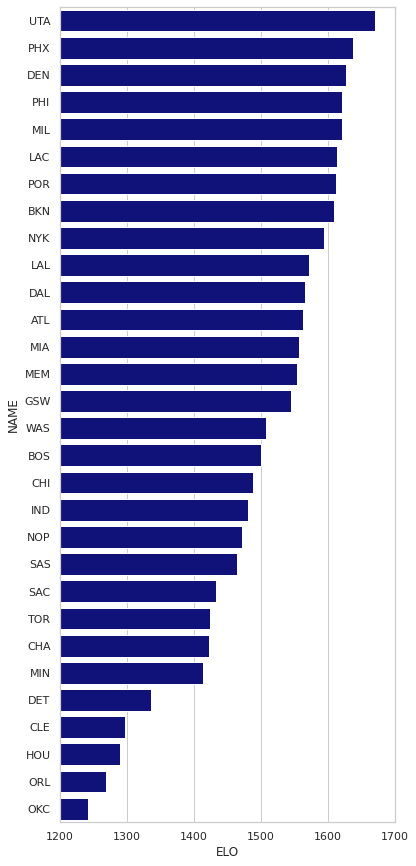

In [ ]:
sn.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))
sn.set_color_codes("pastel")
sn.set_color_codes("pastel")

sn.barplot(x="ELO", y="NAME", data=sorted_team_elo,
            label="ELO", color="darkblue")
ax.set(xlim=(1200, 1700));


##  **Incorporating player efficiency**
Basketball is a sport where key players can have substantial impact on the team's success. Therefore, it is crucial to incorporate this information in the modelling dataset.
This sounds straightforward in theory but in practice there is an important issue to be adressed: There is no all-encompassing metric for efficiency in basketball. The most popular one is the Player efficiency rating (PER) developed by John Hollinger.
Given that not all figures that are required in the calculation are available in the dataset, a different efficiency measure was used: (taken from Breakthroughbasketball)
## Efficiency = Pts + Rebs + Ast + Stl + Blk – (TO + FG Misses + FT Misses)
One benefit that I found in this statistic is that it does filter for games played as the number of all of these figures increases with more games. This means that there is no need for an arbitrary cut-off for season games. Using this efficiency measure the following features were added to the dataset:
1) Players in a team that had a top 30 efficiency rating last season.
2) A measure of "team" efficiency by summing the last season efficiency of all players per team per game

The player efficiency figures for the 2019 season can be seen below:

In [ ]:
# https://en.wikipedia.org/wiki/Player_efficiency_rating

In [ ]:
details['FGMISSES'] = details.FGA - details.FGM
details['FTMISSES'] = details.FTA - details.FTM
details['EFF'] = details.PTS + details.REB + details.AST + details.STL + details.BLK - (details.TO + details.FGMISSES + details.FTMISSES)

# Creating the efficiency dataset
eff = details[['PLAYER_NAME', 'PLAYER_ID', 'SEASON', 'EFF']].copy()
eff.dropna(inplace=True)
eff = eff.groupby(['PLAYER_NAME', 'PLAYER_ID', 'SEASON'], as_index=False).sum()
eff.sort_values('EFF', ascending=False, inplace=True)
top_players = eff.groupby('SEASON', as_index=False).head(300).copy()  ####
top_players['NEXT_SEASON'] = top_players.SEASON + 1
eff['NEXT_SEASON'] = eff.SEASON + 1

# Efficiency per game per team
per_game_eff = details.loc[details.COMMENT.isnull()][['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'SEASON']].merge(eff, left_on=['PLAYER_ID', 'SEASON'], right_on=['PLAYER_ID', 'NEXT_SEASON'], how='left')
pge = per_game_eff.groupby(['GAME_ID', 'TEAM_ID'], as_index=False).EFF.mean()
pge.dropna(inplace= True)

# Top players based on efficiecy for the 2019 season
top_players.loc[top_players.SEASON == 2019, ['PLAYER_NAME', 'EFF']].T

,2971,3564,6307,5181,3149,2328,493,5318,7163,664,1692,8038,318,2226,2021,860,7180,4278,1418,4613,701,6328,3865,4502,4056,7935,899,2356,8553,6123,7394,4864,4143,4802,3701,1089,6467,7561,5069,4475,5021,4182,4954,7670,2262,1060,4602,6954,3361,2108,1522,7716,102,6083,7802,8133,8448,4665,6207,810,22,1784,433,3513,1992,2676,1461,1496,2766,4679,5240,6966,3855,5281,3130,7364,3032,2077,1974,5406,1609,5137,5628,1772,3301,7942,6367,160,4100,3688,2845,6053,6157,4093,1510,6556,5653,2187,5556,2470,7902,4687,2439,5813,2702,1968,1023,887,6446,2170,2391,5948,4310,3426,3017,5564,6448,6927,2193,8137,3002,2083,2070,3291,3936,7792,2296,1837,4785,7752,2363,3388,7830,5151,3916,8410,4401,791,7129,1032,6237,1192,1225,7155,2665,7380,1500,1976,803,8470,2614,6347,3344,3040,7709,1831,1711,3456,4533,2418,8121,6572,7851,6117,6681,4434,8272,2919,5119,4659,7392,6490,3955,5716,7165,6525,4448,2175,185,4730,8095,3847,2404,4982,4738,4935,746,7734,2885,5006,6088,7770,2871,1565,1052,1137,2477,606,1810,1979,35,7076,1622,3375,2745,4288,1120,696,5049,1841,2851,3459,5971,8195,5802,3397,8011,6475,3703,5638,5431,1683,5438,1347,851,5486,640,5856,4824,6724,8437,6129,451,6386,7693,3552,5910,2830,6033,3212,5338,3248,8602,7980,5708,5880,1124,5112,6294,4347,174,2822,7537,651,3278,4789,2506,4976,2273,7864,3133,2905,4193,4352,2656,1041,7002,1502,2002,4489,5721,8023,3576,5003,7518,4537,3053,2927,3899,1839,7197,1752,5600,2690,7397,4342,5233,1309,773,4855,1732,6186,4037,4620,8416,51,8337,7622,6879,7433
PLAYER_NAME,Giannis Antetokounmpo,James Harden,Nikola Jokic,LeBron James,Hassan Whiteside,Domantas Sabonis,Anthony Davis,Luka Doncic,Rudy Gobert,Bam Adebayo,Damian Lillard,Trae Young,Andre Drummond,Devin Booker,DeMar DeRozan,Bradley Beal,Russell Westbrook,Jonas Valanciunas,Chris Paul,Kawhi Leonard,Ben Simmons,Nikola Vucevic,Jayson Tatum,Julius Randle,Jimmy Butler,Tobias Harris,Brandon Ingram,Donovan Mitchell,Zach LaVine,Montrezl Harrell,Shai Gilgeous-Alexander,Khris Middleton,Joel Embiid,Kevin Love,Jarrett Allen,CJ McCollum,Pascal Siakam,Spencer Dinwiddie,LaMarcus Aldridge,Jrue Holiday,Kyle Lowry,John Collins,Kristaps Porzingis,Steven Adams,Devonte' Graham,Buddy Hield,Karl-Anthony Towns,Ricky Rubio,Ja Morant,Dennis Schroder,Collin Sexton,T.J. Warren,Al Horford,Mitchell Robinson,Terry Rozier,Tristan Thompson,Will Barton,Kelly Oubre Jr.,Nemanja Bjelica,Bojan Bogdanovic,Aaron Gordon,Danilo Gallinari,Andrew Wiggins,Jamal Murray,DeAndre Jordan,Eric Bledsoe,Christian Wood,Clint Capela,Evan Fournier,Kemba Walker,Lonzo Ball,Robert Covington,Jaylen Brown,Lou Williams,Harrison Barnes,Serge Ibaka,Gordon Hayward,Dejounte Murray,De'Aaron Fox,Malcolm Brogdon,D'Angelo Russell,Larry Nance Jr.,Markelle Fultz,Daniel Theis,Ivica Zubac,Tomas Satoransky,OG Anunoby,Alec Burks,Joe Ingles,Jaren Jackson Jr.,Fred VanVleet,Miles Bridges,Myles Turner,Joe Harris,Cody Zeller,Paul George,Marquese Chriss,Derrick Rose,Marcus Morris Sr.,Dwight Howard,Tim Hardaway Jr.,Kendrick Nunn,Duncan Robinson,Maxi Kleber,Eric Paschall,Davis Bertans,Brook Lopez,Brandon Clarke,P.J. Tucker,Derrick Favors,Dorian Finney-Smith,Mikal Bridges,Jordan Clarkson,Jae Crowder,Goran Dragic,Marcus Smart,P.J. Washington,Richaun Holmes,Derrick White,Troy Brown Jr.,Glenn Robinson III,Delon Wright,Deandre Ayton,Ish Smith,Jerami Grant,Terrence Ross,Dillon Brooks,Dario Saric,Kevin Huerter,Taurean Prince,Donte DiVincenzo,JaVale McGee,Thaddeus Young,Lauri Markkanen,Jeff Teague,Wendell Carter Jr.,Josh Hart,Bobby Portis,Royce O'Neale,Bruce Brown,Nerlens Noel,Carmelo Anthony,Cedi Osman,Rudy Gay,Enes Kanter,Seth Curry,Coby White,De'Andre Hunter,Bogdan Bogdanovic,Willie Cauley-Stein,Elfrid Payton,Norman Powell,JJ Redick,Gorgui Dieng,T.J. McConnell,Danuel House Jr.,Damion Lee,Jakob Poeltl,Justin Holiday,Draymond Green,Trey Lyles,Paul Millsap,Thomas Bryant,Monte Morris,RJ Barrett,Josh Okogie,Tyus Jones,George Hill,Langston Galloway,Kelly Olynyk,Shabazz Napier,Patrick Beverley,Jeremy Lamb,Mason Plumlee,Rui Hachimura,Patty Mills,Josh Richardson,Derrick Jones Jr.

In [ ]:
# Top players based on efficiecy for the De season
top_players.loc[top_players.SEASON == 2020, ['PLAYER_NAME', 'EFF']].T

,6308,2972,4503,6329,7181,5319,7595,1693,2329,7164,3866,8603,665,1419,4279,1497,8039,4144,861,2071,2227,4865,8554,2022,4614,4603,4057,5050,2666,3565,900,2078,7936,7803,1975,5911,3856,4183,6928,3702,6468,5182,702,4660,434,4476,4983,6557,5407,2419,6682,5949,3362,7831,2357,1523,495,1061,3457,6124,3131,6348,7710,5717,1348,3302,4769,2846,6054,1501,3937,6449,4101,4311,811,792,3428,4646,1090,1024,6967,4094,3514,7903,319,5022,3460,4955,5071,2109,7130,5241,2084,1462,5972,5007,6955,1138,8229,6187,3267,3033,2297,2364,4786,1773,2471,2440,7671,8411,1842,2405,2677,6989,7233,888,1033,4666,8196,7395,6238,494,1993,6288,3900,6158,4534,1193,6514,2263,2392,1811,7166,4688,4856,4680,6880,7003,2171,804,7156,2188,4402,6368,8449,5565,4722,6857,4419,5557,3427,7398,1840,23,1610,5152,6476,3696,4449,3266,8134,4564,2205,7381,1511,1785,6573,4739,2767,4235,2906,5693,1131,1566,2446,7943,3122,3018,161,5432,5282,7769,6811,8273,3848,7737,6143,6526,2615,1520,7365,747,3241,3251,8492,186,1125,1969,7835,8515,1753,7793,4731,4842,8313,761,1226,3376,4485,6118,2785,2478,3057,5303,4752,1980,5814,3418,1053,5339,5234,6597,7623,2176,5138,2194,6089,4353,7735,2068,7981,175,2032,5113,103,338,2422,2872,7694,5487,7771,5639,6084,8471,2928,3577,2100,1712,1481,3389,8230,452,6274,3620,1623,1838,607,3292,2117,5722,6453,2823,2852,3553,8024,2257,7538,3956,2003,4490,4343,3150,3917,5439,7753,3467,852,36,4435,4803,6680,4825,6725,8403,3261,7232,6623,3054,2587,5399,7581,3041,8166,1977,5070,6130,6292,6405,6447,164
PLAYER_NAME,Nikola Jokic,Giannis Antetokounmpo,Julius Randle,Nikola Vucevic,Russell Westbrook,Luka Doncic,Stephen Curry,Damian Lillard,Domantas Sabonis,Rudy Gobert,Jayson Tatum,Zion Williamson,Bam Adebayo,Chris Paul,Jonas Valanciunas,Clint Capela,Trae Young,Joel Embiid,Bradley Beal,Deandre Ayton,Devin Booker,Khris Middleton,Zach LaVine,DeMar DeRozan,Kawhi Leonard,Karl-Anthony Towns,Jimmy Butler,Kyrie Irving,Enes Kanter,James Harden,Brandon Ingram,Dejounte Murray,Tobias Harris,Terry Rozier,De'Aaron Fox,Michael Porter Jr.,Jaylen Brown,John Collins,Richaun Holmes,Jarrett Allen,Pascal Siakam,LeBron James,Ben Simmons,Kelly Olynyk,Andrew Wiggins,Jrue Holiday,Kyle Anderson,Paul George,Malcolm Brogdon,Draymond Green,RJ Barrett,Mikal Bridges,Ja Morant,Thaddeus Young,Donovan Mitchell,Collin Sexton,Anthony Edwards,Buddy Hield,Jakob Poeltl,Montrezl Harrell,Harrison Barnes,Norman Powell,T.J. McConnell,Mason Plumlee,Chris Boucher,Ivica Zubac,Kevin Durant,Fred VanVleet,Miles Bridges,Coby White,Jerami Grant,P.J. Washington,Joe Ingles,Jordan Clarkson,Bojan Bogdanovic,Bobby Portis,Jae'Sean Tate,Keldon Johnson,CJ McCollum,Brook Lopez,Robert Covington,Joe Harris,Jamal Murray,Tim Hardaway Jr.,Andre Drummond,Kyle Lowry,Jalen Brunson,Kristaps Porzingis,LaMelo Ball,Dennis Schroder,Royce O'Neale,Lonzo Ball,Delon Wright,Christian Wood,Mike Conley,Kyle Kuzma,Ricky Rubio,Caris LeVert,Tyrese Haliburton,Naz Reid,Isaiah Stewart,Gordon Hayward,Dillon Brooks,Donte DiVincenzo,Kevin Huerter,Daniel Theis,Dwight Howard,Duncan Robinson,Steven Adams,Wendell Carter Jr.,Darius Garland,Doug McDermott,Eric Bledsoe,Robert Williams III,Saddiq Bey,Brandon Clarke,Bruce Brown,Kelly Oubre Jr.,Tyler Herro,Shai Gilgeous-Alexander,Nerlens Noel,Anthony Davis,DeAndre Jordan,Nicolas Batum,Jeff Green,Myles Turner,Justin Holiday,Carmelo Anthony,Patrick Williams,Devonte' Graham,Dorian Finney-Smith,Danny Green,Rui Hachimura,Kendrick Nunn,Khem Birch,Kemba Walker,Reggie Jackson,Robin Lopez,Derrick Favors,Bogdan Bogdanovic,Rudy Gay,Derrick Rose,Josh Hart,OG Anunoby,Will Barton,Marcus Smart,Kenrich Williams,Reggie Bullock,Josh Jackson,Marcus Morris Sr.,Jae Crowder,Shake Milton,Darius Bazley,Aaron Gordon,D'Angelo Russell,Lauri Markkanen,Pat Connaughton,Jarred Vanderbilt,Josh Richardson,Isaiah Roby,Tristan Thompson,Jusuf Nurkic,Desmond Bane,Seth Curry,Cody Zeller,Danilo Gallinari,Paul Millsap,Kentavious Caldwell-Pope,Evan Fournier,John Wall,Gary Trent Jr.,Marvin Bagley III,Cameron Payne,Cory Joseph,Dwayne Bacon,Tomas Satoransky,Hamidou Diallo,Go

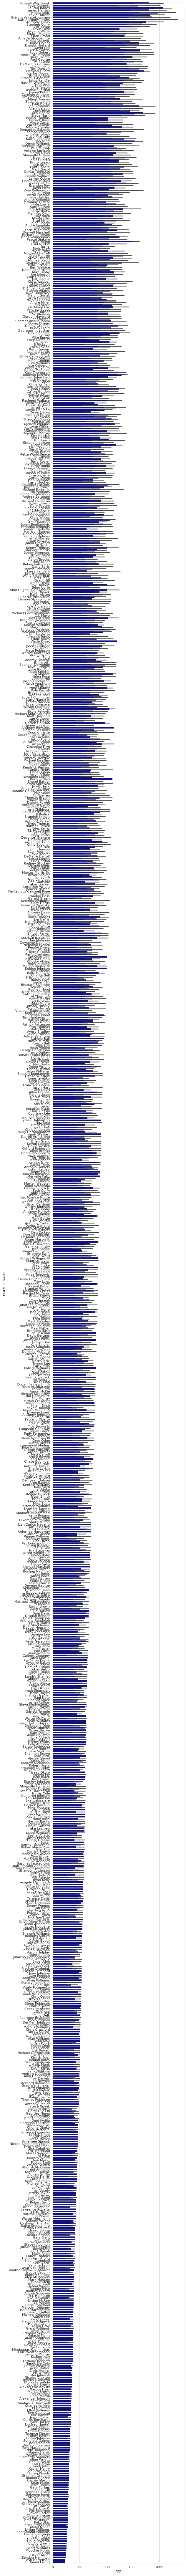

In [ ]:
plt.figure(figsize=(8,160))
font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 2}
plt.rc('font', **font)
sn.set_theme(style="whitegrid")
sn.set_color_codes("pastel")
sn.set_color_codes("pastel")
sn.barplot(x="EFF", y="PLAYER_NAME", data=top_players,
            label="ELO", color="darkblue");
#ax.set(xlim=(1200, 2000));

In [ ]:
top_players_per_game = details.loc[details.COMMENT.isnull()][['GAME_ID', 'TEAM_ID', 'PLAYER_ID', 'SEASON']].merge(top_players, left_on=['PLAYER_ID', 'SEASON'], right_on=['PLAYER_ID', 'NEXT_SEASON'], how='left')
top_players_per_game = top_players_per_game.groupby(['GAME_ID', 'TEAM_ID', 'SEASON_x']).PLAYER_NAME.agg(lambda x: x.notnull().sum()).reset_index()
top_players_per_game.columns = ['GAME_ID', 'TEAM_ID', 'SEASON', 'TOP_PLAYERS']
#top_players_per_game.drop(columns='SEASON', inplace=True)

In [ ]:
top_players_per_game

# Incorporating team fatigue
Players are humans and do get tired throughout the season. In order to measure this in the dataset the following variables are added:

**HG_7days**: Home games in the last 7 days

**AG_7days**: Away games in the last 7 days

**G_7days**: Total games in the last 7 days

**BACK2BACK**: Whether a team played a game the night before


In [ ]:
games_short.head()

,GAME_ID,GAME_DATE_EST,SEASON,HOME_TEAM_ID,VISITOR_TEAM_ID,HOME_TEAM_WINS
15248,20300005,2003-10-29,2003,1610612752,1610612753,0
15249,20300004,2003-10-29,2003,1610612738,1610612748,1
15250,20300009,2003-10-29,2003,1610612750,1610612749,1
15251,20300008,2003-10-29,2003,1610612765,1610612754,0
15252,20300010,2003-10-29,2003,1610612741,1610612764,0


In [ ]:
games_played = pd.melt(games_short, id_vars = ['GAME_ID', 'GAME_DATE_EST'], value_vars = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID']).set_index('GAME_DATE_EST')
games_played['HOME_GAME'] = np.where(games_played.variable == "HOME_TEAM_ID", True, False)
games_played.drop(columns = 'variable', inplace = True)
games_played.rename(columns = {'value':'TEAM_ID'}, inplace = True)
games_played.sort_values(['TEAM_ID', 'GAME_DATE_EST'], inplace = True)

# Games in the last week # FAIRE DES TESTS 
games_played['HG_7days'] = games_played.groupby('TEAM_ID').HOME_GAME.apply(lambda x: x.rolling(window = "7d", closed='left', min_periods=0).sum())  # 14d
games_played['AG_7days'] = games_played.groupby('TEAM_ID').HOME_GAME.apply(lambda x: (~x).rolling(window = "7d", closed='left', min_periods=0).sum())
games_played['G_7days'] = games_played['HG_7days'] + games_played['AG_7days']

In [ ]:
games_played.head()

,GAME_ID,TEAM_ID,HOME_GAME,HG_7days,AG_7days,G_7days
GAME_DATE_EST,,,,,,
2003-10-29,20300006,1610612737,False,0.0,0.0,0.0
2003-10-31,20300024,1610612737,False,0.0,1.0,1.0
2003-11-01,20300029,1610612737,True,0.0,2.0,2.0
2003-11-03,20300042,1610612737,True,1.0,2.0,3.0
2003-11-05,20300060,1610612737,False,2.0,2.0,4.0


In [ ]:
# Back to back games
games_played.reset_index(inplace=True)
games_played['PAST_GAME'] = games_played.groupby(['TEAM_ID']).GAME_DATE_EST.transform(lambda x: x.shift(periods=1))
games_played['BACK2BACK'] = np.where((games_played.GAME_DATE_EST - games_played.PAST_GAME).dt.days == 1, 1, 0)
games_played.drop(columns = ['PAST_GAME', 'GAME_DATE_EST', 'HOME_GAME'], inplace=True)

In [ ]:
games_played.head()

,GAME_ID,TEAM_ID,HG_7days,AG_7days,G_7days,BACK2BACK
0,20300006,1610612737,0.0,0.0,0.0,0
1,20300024,1610612737,0.0,1.0,1.0,0
2,20300029,1610612737,0.0,2.0,2.0,1
3,20300042,1610612737,1.0,2.0,3.0,0
4,20300060,1610612737,2.0,2.0,4.0,0


In [ ]:
# Création dataset de modelisation
# Combining all the data to create the full dataset
input_data = pd.merge_asof(games_short, ranking_short, left_on = 'GAME_DATE_EST', right_on = 'STANDINGSDATE', left_by = 'HOME_TEAM_ID', right_by = 'TEAM_ID', allow_exact_matches = False)
input_data = input_data.loc[~input_data.TEAM_ID.isnull()]
input_data = pd.merge_asof(input_data, ranking_short.add_suffix("_VISITOR"), left_on = 'GAME_DATE_EST', right_on = 'STANDINGSDATE_VISITOR', 
                     left_by = 'VISITOR_TEAM_ID', right_by = 'TEAM_ID_VISITOR', allow_exact_matches = False)

input_data.loc[(input_data.GAME_DATE_EST.dt.month <= 12) & (input_data.GAME_DATE_EST.dt.month > 9) & (input_data.G > 50), ['G', 'W', 'L', 'HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']] = 0
input_data.loc[(input_data.GAME_DATE_EST.dt.month <= 12) & (input_data.GAME_DATE_EST.dt.month > 9) & (input_data.G_VISITOR > 50), ['G_VISITOR', 'W_VISITOR', 'L_VISITOR', 'HOME_W_VISITOR', 'HOME_L_VISITOR', 'AWAY_W_VISITOR', 'AWAY_L_VISITOR']] = 0

#Adding top players
input_data = input_data.merge(top_players_per_game, left_on=['HOME_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_something'))
input_data = input_data.merge(top_players_per_game, left_on=['VISITOR_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_VISITOR'))
input_data.drop(columns=['TEAM_ID_something', 'TEAM_ID_VISITOR'], inplace=True)

#Adding player efficiency
input_data = input_data.merge(pge, left_on=['HOME_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_something'))
input_data = input_data.merge(pge, left_on=['VISITOR_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_VISITOR'))
input_data.drop(columns=['TEAM_ID_something', 'TEAM_ID_VISITOR'], inplace=True)

#Adding team fatigue
input_data = input_data.merge(games_played, left_on=['HOME_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_something'))
input_data = input_data.merge(games_played, left_on=['VISITOR_TEAM_ID', 'GAME_ID'], right_on=['TEAM_ID', 'GAME_ID'], suffixes=('','_VISITOR'))
input_data.drop(columns=['TEAM_ID_something', 'TEAM_ID_VISITOR'], inplace=True)

In [ ]:
# Adding ELO
input_data = input_data.merge(elo_data[['GAME_ID', 'HOME_ELO', 'VISITOR_ELO']])

input_data['HOME_TEAM'] = input_data['HOME_TEAM_ID'].map(teams_dict)
input_data['VISITOR_TEAM'] = input_data['VISITOR_TEAM_ID'].map(teams_dict)

#input_data = input_data.drop(columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'TEAM_ID', 'TEAM', 'TEAM_ID_x', 'TEAM_ID_y', 'STANDINGSDATE', 'TEAM_VISITOR', 'STANDINGSDATE_VISITOR'])
input_data = input_data.drop(columns = ['TEAM', 'TEAM_VISITOR'])
input_data['ELO_DIFF'] = input_data.HOME_ELO - input_data.VISITOR_ELO
input_data['TOP_PLAYER_DIFF'] = input_data.TOP_PLAYERS - input_data.TOP_PLAYERS_VISITOR
#input_data['MISSING_PLAYER_DIFF'] = input_data.MISSING_PLAYERS - input_data.MISSING_PLAYERS_VISITOR
input_data['EFF_DIFF'] = input_data.EFF - input_data.EFF_VISITOR
input_data['MONTH'] = input_data.GAME_DATE_EST.dt.month

input_data.drop(columns = ['HOME_TEAM', 'VISITOR_TEAM', 'CONFERENCE', 'CONFERENCE_VISITOR', 'GAME_DATE_EST'], inplace=True)

In [ ]:
input_data.head(10)

,GAME_ID,SEASON,HOME_TEAM_ID,VISITOR_TEAM_ID,HOME_TEAM_WINS,TEAM_ID,STANDINGSDATE,G,W,L,HOME_W,HOME_L,AWAY_W,AWAY_L,STANDINGSDATE_VISITOR,G_VISITOR,W_VISITOR,L_VISITOR,HOME_W_VISITOR,HOME_L_VISITOR,AWAY_W_VISITOR,AWAY_L_VISITOR,SEASON_something,TOP_PLAYERS,SEASON_VISITOR,TOP_PLAYERS_VISITOR,EFF,EFF_VISITOR,HG_7days,AG_7days,G_7days,BACK2BACK,HG_7days_VISITOR,AG_7days_VISITOR,G_7days_VISITOR,BACK2BACK_VISITOR,HOME_ELO,VISITOR_ELO,ELO_DIFF,TOP_PLAYER_DIFF,EFF_DIFF,MONTH
0,20400014,2004,1610612762,1610612747,1,1.610613e+09,2004-04-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-11-02,1,1,0,1,0,0,0,2004,8,2004,8,743.100000,616.545455,0.0,0.0,0.0,0,0.0,0.0,0.0,0,1591.965487,1591.476724,0.488763,0,126.554545,11
1,20400004,2004,1610612761,1610612745,1,1.610613e+09,2004-04-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-11-02,1,0,1,0,0,0,1,2004,7,2004,9,800.777778,802.454545,0.0,0.0,0.0,0,0.0,0.0,0.0,0,1513.145510,1524.831640,-11.686130,-2,-1.676768,11
2,20400005,2004,1610612753,1610612749,1,1.610613e+09,2004-04-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-04-14,0,0,0,0,0,0,0,2004,6,2004,8,740.000000,776.111111,0.0,0.0,0.0,0,0.0,0.0,0.0,0,1444.315322,1500.258568,-55.943246,-2,-36.111111,11
3,20400015,2004,1610612746,1610612760,1,1.610613e+09,2004-04-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-04-14,0,0,0,0,0,0,0,2004,5,2004,8,612.888889,797.875000,0.0,0.0,0.0,0,0.0,0.0,0.0,0,1475.438161,1506.114060,-30.675899,-3,-184.986111,11
4,20400012,2004,1610612759,1610612758,1,1.610613e+09,2004-04-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-11-02,1,0,1,0,0,0,1,2004,10,2004,9,759.909091,988.555556,0.0,0.0,0.0,0,0.0,0.0,0.0,0,1758.345361,1564.230436,194.114925,1,-228.646465,11
5,20400011,2004,1610612750,1610612752,1,1.610613e+09,2004-04-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-04-14,0,0,0,0,0,0,0,2004,9,2004,10,840.700000,832.500000,0.0,0.0,0.0,0,0.0,0.0,0.0,0,1738.332591,1478.877341,259.455249,-1,8.200000,11
6,20400013,2004,1610612756,1610612737,1,1.610613e+09,2004-04-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-04-14,0,0,0,0,0,0,0,2004,9,2004,7,852.200000,575.500000,0.0,0.0,0.0,0,0.0,0.0,0.0,0,1545.900325,1431.683348,114.216977,2,276.700000,11
7,20400006,2004,1610612739,1610612754,0,1.610613e+09,2004-04-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-04-14,0,0,0,0,0,0,0,2004,10,2004,5,782.800000,553.875000,0.0,0.0,0.0,0,0.0,0.0,0.0,0,1558.481636,1619.234137,-60.752500,5,228.925000,11
8,20400007,2004,1610612738,1610612755,0,1.610613e+09,2004-04-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-04-14,0,0,0,0,0,0,0,2004,8,2004,8,847.000000,591.454545,0.0,0.0,0.0,0,0.0,0.0,0.0,0,1552.880907,1422.040898,130.840009,0,255.545455,11
9,20400016,2004,1610612744,1610612757,0,1.610613e+09,2004-04-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2004-04-14,0,0,0,0,0,0,0,2004,10,2004,8,666.400000,1038.125000,0.0,0.0,0.0,0,0.0,0.0,0.0,0,1597.626776,1510.253231,87.373545,2,-371.725000,11


In [ ]:
# Splitting the data
train_data = input_data.loc[(input_data.SEASON < 2019) & (input_data.SEASON > 2016)]  ### CLE
valid_data = input_data.loc[input_data.SEASON == 2019]
test_data = input_data.loc[input_data.SEASON == 2020]
full_train_data = pd.concat([train_data, valid_data], axis = 0)

X, y = train_data.drop(columns = ['HOME_TEAM_WINS']), train_data.HOME_TEAM_WINS
valid_X, valid_y = valid_data.drop(columns = ['HOME_TEAM_WINS']), valid_data.HOME_TEAM_WINS
test_X, test_y = test_data.drop(columns = ['HOME_TEAM_WINS']), test_data.HOME_TEAM_WINS
full_train_X, full_train_y = full_train_data.drop(columns = ['HOME_TEAM_WINS', 'SEASON', 'GAME_ID']), full_train_data.HOME_TEAM_WINS

train_games = X[['SEASON', 'GAME_ID']]
valid_games = valid_X[['SEASON', 'GAME_ID']]
test_games = test_X[['SEASON', 'GAME_ID']]

X.drop(columns = ['SEASON', 'GAME_ID'], inplace=True)
valid_X.drop(columns = ['SEASON', 'GAME_ID'], inplace = True)
test_X.drop(columns = ['SEASON', 'GAME_ID'], inplace = True)

In [ ]:
full_train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3425 entries, 15706 to 19130
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   HOME_TEAM_ID           3425 non-null   int64         
 1   VISITOR_TEAM_ID        3425 non-null   int64         
 2   TEAM_ID                3425 non-null   float64       
 3   STANDINGSDATE          3425 non-null   datetime64[ns]
 4   G                      3425 non-null   float64       
 5   W                      3425 non-null   float64       
 6   L                      3425 non-null   float64       
 7   HOME_W                 3425 non-null   float64       
 8   HOME_L                 3425 non-null   float64       
 9   AWAY_W                 3425 non-null   float64       
 10  AWAY_L                 3425 non-null   float64       
 11  STANDINGSDATE_VISITOR  3425 non-null   datetime64[ns]
 12  G_VISITOR              3425 non-null   int64         
 13

In [ ]:
test_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1078 entries, 19131 to 20208
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   HOME_TEAM_ID           1078 non-null   int64         
 1   VISITOR_TEAM_ID        1078 non-null   int64         
 2   TEAM_ID                1078 non-null   float64       
 3   STANDINGSDATE          1078 non-null   datetime64[ns]
 4   G                      1078 non-null   float64       
 5   W                      1078 non-null   float64       
 6   L                      1078 non-null   float64       
 7   HOME_W                 1078 non-null   float64       
 8   HOME_L                 1078 non-null   float64       
 9   AWAY_W                 1078 non-null   float64       
 10  AWAY_L                 1078 non-null   float64       
 11  STANDINGSDATE_VISITOR  1078 non-null   datetime64[ns]
 12  G_VISITOR              1078 non-null   int64         
 13

Afin de tirer pleinement parti de l'ensemble de données, nous allons tuner les paramètres en fonction de l'ensemble de validation et après avoir sélectionné les meilleurs, nous allons reutiliser le modèle sur la validation et l'ensemble d'apprentissage avant de faire les prédictions finales.
Pour générer les prédictions, nous allons utiliser CatBoost

**Prédiction simple**

1) Le résultat du jeu sera le même que le résultat de la rencontre précédente entre les mêmes équipes

2) L'équipe à domicile va gagner. Généralement, l'équipe à domicile a un avantage statistique en NBA (comme dans la plupart des sports)


In [ ]:
def calc_accuracy(model, test_X, test_y):
    return(np.round(accuracy_score(model.predict(test_X), test_y)*100,2))
    
def add_accuracy(model, model_name, test_X, test_y):
    test_acc = calc_accuracy(model, test_X, test_y)
    resultats_l.append([model_name, test_acc, len(test_X.columns)])
    print(model_name + ' test accuracy: ' + str(test_acc) + ' %')
    
resultats_l = []


In [ ]:
games_short.sort_values("GAME_DATE_EST", inplace=True)
naive = pd.merge_asof(games_short, games_short[['GAME_DATE_EST', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'HOME_TEAM_WINS']], on = 'GAME_DATE_EST', by = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID'], allow_exact_matches = False, suffixes=(['', '_p']))
naive = naive.dropna()

print('Resultat identique au dernier match: ' + str(np.round(accuracy_score(naive.HOME_TEAM_WINS, naive.HOME_TEAM_WINS_p)*100,2)) + ' %')
print("Victoire de l'équipe à domicile : " + str(np.round(accuracy_score(games_short.HOME_TEAM_WINS, np.repeat(1, games_short.shape[0]))*100,2)) + ' %')

resultats_l.append(['Resultat identique au dernier match', np.round(accuracy_score(naive.HOME_TEAM_WINS, naive.HOME_TEAM_WINS_p)*100,2), 1])
resultats_l.append(["Victoire de l'équipe à domicile", np.round(accuracy_score(games_short.HOME_TEAM_WINS, np.repeat(1, games_short.shape[0]))*100,2), 0])

Resultat identique au dernier match: 57.98 %
Victoire de l'équipe à domicile : 59.01 %


**Prédiction ELO**

In [ ]:
print('ELO accuracy: ' + str(np.round(accuracy_score(test_X.ELO_DIFF >= 0, test_y)*100,2)) + ' %')
resultats_l.append(['ELO', accuracy_score(test_X.ELO_DIFF >= 0, test_y)*100, 1])

ELO accuracy: 61.13 %


**Catboost model**

In [ ]:
catb = CatBoostClassifier(verbose=False)
catb.fit(full_train_X, full_train_y)
add_accuracy(catb, 'Full model', test_X, test_y)

Full model test accuracy: 64.1 %


In [ ]:
# AVEC CROSS VAL
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('catb2_CV', CatBoostClassifier(verbose=False)))
model = Pipeline(estimators)
X = full_train_X
y = full_train_y

kfold = KFold(n_splits=5)
results = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
results = np.round(np.mean(results),3)
print ('CV Scoring Result: ACC0=',results)

CV Scoring Result: ACC0= nan


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: invalid type promotion



 **Autres modèles**

In [ ]:
# step 1 -> modification des datetimes values => int

In [ ]:
full_train_X['STANDINGSDATE'] = full_train_X['STANDINGSDATE'].dt.dayofyear
full_train_X['STANDINGSDATE_VISITOR'] = full_train_X['STANDINGSDATE_VISITOR'].dt.dayofyear

In [ ]:
full_train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3425 entries, 15706 to 19130
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   HOME_TEAM_ID           3425 non-null   int64  
 1   VISITOR_TEAM_ID        3425 non-null   int64  
 2   TEAM_ID                3425 non-null   float64
 3   STANDINGSDATE          3425 non-null   int64  
 4   G                      3425 non-null   float64
 5   W                      3425 non-null   float64
 6   L                      3425 non-null   float64
 7   HOME_W                 3425 non-null   float64
 8   HOME_L                 3425 non-null   float64
 9   AWAY_W                 3425 non-null   float64
 10  AWAY_L                 3425 non-null   float64
 11  STANDINGSDATE_VISITOR  3425 non-null   int64  
 12  G_VISITOR              3425 non-null   int64  
 13  W_VISITOR              3425 non-null   int64  
 14  L_VISITOR              3425 non-null   int64  
 15 

In [ ]:
# Construct the pipeline with a standard scaler and a small neural network
estimators1 = []
estimators1.append(('standardize', StandardScaler()))
estimators1.append(('nn', MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000)))
model1 = Pipeline(estimators1)
X = full_train_X.values
y = full_train_y.values
# We'll use 5-fold cross validation. That is, a random 80% of the data will be used
# to train the model, and the prediction score will be computed on the remaining 20%.
# This process is repeated five times such that the training sets in each "fold"
# are mutually orthogonal.
kfold = KFold(n_splits=5)
results1 = cross_val_score(model1, X, y, cv=kfold, scoring='accuracy')
results1 = np.round(np.mean(results1),3)
print ('CV Scoring Result: ACC1=',results)

CV Scoring Result: ACC1= nan


In [ ]:
estimators2 = []
estimators2.append(('standardize', StandardScaler()))
estimators2.append(('rf', RandomForestClassifier(n_estimators=500)))
model2 = Pipeline(estimators2)
X = full_train_X.values
y = full_train_y.values
kfold = KFold(n_splits=5)
results2 = cross_val_score(model2, X, y, cv=kfold, scoring='accuracy')
results2 = np.round(np.mean(results2),3)
print ('CV Scoring Result: ACC2=',results2)

CV Scoring Result: ACC2= 0.673


In [ ]:
#add_accuracy(results2, 'Full model_RF', test_X, test_y)

# 'numpy.float64' object has no attribute 'predict'

In [ ]:
estimators3 = []
estimators3.append(('standardize', StandardScaler()))
estimators3.append(('ad', AdaBoostClassifier(n_estimators=100, learning_rate=.5)))
model3 = Pipeline(estimators3)
X = full_train_X.values
y = full_train_y.values
kfold = KFold(n_splits=5)
results3 = cross_val_score(model3, X, y, cv=kfold, scoring='accuracy')
results3 = np.round(np.mean(results3),3)
print ('CV Scoring Result: ACC3=',results3)

CV Scoring Result: ACC3= 0.655


In [ ]:
#add_accuracy(results3, 'Full model_ADAB', test_X, test_y)

### **Feature selection**

In [ ]:
# simple filtering CATBOOST

pipe = Pipeline([
    ('reduce_dim', SelectKBest(f_classif)),
    ('classify', CatBoostClassifier(verbose=False))
])

param_grid = [
      { 'reduce_dim__k': [8, 10, 12],
        'classify__depth':[3, 5, 7]}]

sf_grid = GridSearchCV(pipe, n_jobs=-1, param_grid=param_grid)
_ = sf_grid.fit(X, y)

In [ ]:
features_selected = sf_grid.best_params_['reduce_dim__k']
print("The GridSearch selected " + str(features_selected) + ' features with a tree depth of ' + str(sf_grid.best_params_['classify__depth']))


The GridSearch selected 10 features with a tree depth of 5


In [ ]:
feature_score_df = pd.DataFrame({'Feature':full_train_X.columns, 'Score':sf_grid.best_estimator_['reduce_dim'].scores_}).sort_values(by='Score', ascending=False).head(features_selected)
feature_score_df

,Feature,Score
35,ELO_DIFF,483.964414
33,HOME_ELO,297.470981
37,EFF_DIFF,207.781860
34,VISITOR_ELO,179.211346
23,EFF,98.303183
36,TOP_PLAYER_DIFF,93.414331
24,EFF_VISITOR,93.066522
8,HOME_L,84.985698
6,L,67.310776
20,TOP_PLAYERS,59.382599


In [ ]:
# simple filtering RANDOMFOREST

pipe2 = Pipeline([
    ('reduce_dim', SelectKBest(f_classif)),
    ('classify', RandomForestClassifier())
])

param_grid2 = [{'reduce_dim__k': [8, 10, 12],'classify__min_samples_leaf': [2, 3, 5], 'classify__n_estimators': [100, 500, 1000] }]

sf_grid = GridSearchCV(pipe2, n_jobs=-1, param_grid=param_grid2)
_ = sf_grid.fit(X, y)

In [ ]:
sf_grid.best_params_

{'classify__min_samples_leaf': 5,
 'classify__n_estimators': 1000,
 'reduce_dim__k': 12}

In [ ]:
features_selected_2 = sf_grid.best_params_['reduce_dim__k']

In [ ]:
feature_score_df = pd.DataFrame({'Feature':full_train_X.columns, 'Score':sf_grid.best_estimator_['reduce_dim'].scores_}).sort_values(by='Score', ascending=False).head(features_selected_2)
feature_score_df

,Feature,Score
35,ELO_DIFF,483.964414
33,HOME_ELO,297.470981
37,EFF_DIFF,207.781860
34,VISITOR_ELO,179.211346
23,EFF,98.303183
36,TOP_PLAYER_DIFF,93.414331
24,EFF_VISITOR,93.066522
8,HOME_L,84.985698
6,L,67.310776
20,TOP_PLAYERS,59.382599


In [ ]:
#rf = RandomForestClassifier(verbose=False)
#rf.get_params().keys()


In [ ]:
# simple MLPClassifier
#pipe3 = Pipeline([
#    ('reduce_dim', SelectKBest(f_classif)),
#    ('classify', MLPClassifier())
#])
# param_grid3 = [{'reduce_dim__k': [8, 10, 12],'classify__hidden_layer_sizes': [5, 10, 15], 'classify__activation': [logistic, tanh, relu] }]
# sf_grid = GridSearchCV(pipe3, n_jobs=-1, param_grid=param_grid3)
# _ = sf_grid.fit(X, y)

## Importance de la permutation
### L'idée derrière l'importance de la permutation pour une seule caractéristique est très simple :
### 1) Calculer l'erreur globale du modèle
### 2) Mélangez les valeurs de la fonctionnalité de manière aléatoire afin de briser toute association entre la fonctionnalité et le résultat
### 3) Calculer de combien l'erreur du modèle change avec le nouveau brassage

In [ ]:
# https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html

In [ ]:
X.head(1) # recréer X avant (anti chronologique)

,HOME_TEAM_ID,VISITOR_TEAM_ID,TEAM_ID,STANDINGSDATE,G,W,L,HOME_W,HOME_L,AWAY_W,AWAY_L,STANDINGSDATE_VISITOR,G_VISITOR,W_VISITOR,L_VISITOR,HOME_W_VISITOR,HOME_L_VISITOR,AWAY_W_VISITOR,AWAY_L_VISITOR,SEASON_something,TOP_PLAYERS,SEASON_VISITOR,TOP_PLAYERS_VISITOR,EFF,EFF_VISITOR,HG_7days,AG_7days,G_7days,BACK2BACK,HG_7days_VISITOR,AG_7days_VISITOR,G_7days_VISITOR,BACK2BACK_VISITOR,HOME_ELO,VISITOR_ELO,ELO_DIFF,TOP_PLAYER_DIFF,EFF_DIFF,MONTH
15706,1610612765,1610612766,1.610613e+09,2017-04-12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2017-04-12,0,0,0,0,0,0,0,2017,8,2017,6,818.0,981.571429,0.0,0.0,0.0,0,0.0,0.0,0.0,0,1551.918453,1469.137054,82.781399,2,-163.571429,10


In [ ]:
X.shape

(2456, 39)

In [ ]:
y.shape

(2456,)

In [ ]:
# triche pour débugger X_bis à la place de X
X_bis=X.drop(['STANDINGSDATE','STANDINGSDATE_VISITOR'], axis=1)

## permutation importance

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    best_valid_acc = 0
    for features in [8, 10, 12]:
        for depth in [3,5,7]:
            pi_catb = CatBoostClassifier( mns[np.argpartition(perm.feature_importances_, -features)[-features:]].tolist()

            valid_X_pi = valid_X[selected_columns]
            pi_catb.fit(X_bis[selected_columns], y)

            valid_acc = np.round(accuracy_score(pi_catb.predict(valid_X_pi), valid_y),3)
            if valid_acc > best_valid_acc:
                pi_features = selected_columns
                pi_depth = depth
                best_valid_acc = valid_acc    

full_train_X_pi = full_train_X[pi_features]
test_X_pi = test_X[pi_features]
pi_model = CatBoostClassifier(verbose=False, depth=pi_depth)
pi_model.fit(full_train_X_pi, full_train_y)

In [ ]:
pd.DataFrame(pi_features[::-1], columns = ['Features'])

,Features
0,EFF
1,EFF_DIFF
2,HOME_ELO
3,ELO_DIFF
4,EFF_VISITOR
5,BACK2BACK_VISITOR
6,AWAY_W_VISITOR
7,VISITOR_ELO


In [ ]:
# catboostmodel
add_accuracy(pi_model, 'Permutation importance', test_X_pi, test_y)

Permutation importance test accuracy: 64.19 %


In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    best_valid_acc = 0
    for features in [8, 10, 12]:
        #for depth in [3,5,7]:
            pi_rf = RandomForestClassifier(verbose=False)
            perm = PermutationImportance(estimator=pi_rf, cv=3).fit(X_bis.reset_index(drop=True), y.reset_index(drop=True))
            selected_columns = X_bis.columns[np.argpartition(perm.feature_importances_, -features)[-features:]].tolist()

            valid_X_pi = valid_X[selected_columns]
            pi_rf.fit(X_bis[selected_columns], y)

            valid_acc = np.round(accuracy_score(pi_rf.predict(valid_X_pi), valid_y),3)
            if valid_acc > best_valid_acc:
                pi_features = selected_columns
                #pi_depth = depth
                best_valid_acc = valid_acc    

full_train_X_pi = full_train_X[pi_features]
test_X_pi = test_X[pi_features]
pi_model = RandomForestClassifier(verbose=False)
pi_model.fit(full_train_X_pi, full_train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=False, warm_start=False)

In [ ]:
pd.DataFrame(pi_features[::-1], columns = ['Features'])

,Features
0,BACK2BACK_VISITOR
1,EFF_DIFF
2,EFF_VISITOR
3,ELO_DIFF
4,VISITOR_ELO
5,HOME_ELO
6,EFF
7,L
8,AG_7days
9,TOP_PLAYERS


In [ ]:
# randomforest
add_accuracy(pi_model, 'Permutation importance', test_X_pi, test_y)

Permutation importance test accuracy: 62.24 %


## Feature importance avec le modèle baseline "CATBOOST"
Par feature importance : dans le contexte d'un arbre de boost, on entend ce qui suit : Quelle est l'efficacité (en termes de réduction de la perte ou de l'impureté des nœuds) est-ce que les divisions basées sur chaque attribut particulier ? Il y a plusieurs facteurs à prendre en compte ici :

L'efficacité est pondérée par le nombre d'observations à chaque division, de sorte que les divisions qui se produisent plus haut dans l'arbre ont plus d'impact (plus nous descendons dans l'arbre de décision, moins il y a d'observations à diviser)
Le nombre d'arbres utilisant un attribut pour un fractionnement est important ici. Plus d'arbres utilisant l'attribut pour un fractionnement --> Score plus élevé pour l'attribut

In [ ]:
train_pool = Pool(X, y)
best_valid_acc = 0

for features in [8, 10, 12]:
    for depth in [3, 5, 7]:
        fi_catb = CatBoostClassifier(verbose=False, depth = depth)
        summary = fi_catb.select_features(X=train_pool, 
                                features_for_select=X.columns.to_list(),
                                num_features_to_select = features,
                                steps = 3,
                                logging_level='Silent',
                                train_final_model=True,
                                algorithm = 'RecursiveByLossFunctionChange',
                                plot=False)
        valid_acc = np.round(accuracy_score(fi_catb.predict(valid_X), valid_y),3)
        if valid_acc > best_valid_acc:
            fi_model = fi_catb
            fi_depth = depth
            fi_features = summary['selected_features_names']
            best_valid_acc = valid_acc

full_train_X_fi = full_train_X[fi_features]
test_X_fi = test_X[fi_features]
fi_model = CatBoostClassifier(verbose=False, depth=fi_depth)
fi_model.fit(full_train_X_fi, full_train_y)

In [ ]:
pd.DataFrame(fi_features[::-1], columns = ['Features'])

,Features
0,EFF_DIFF
1,ELO_DIFF
2,VISITOR_ELO
3,HOME_ELO
4,EFF_VISITOR
5,EFF
6,TOP_PLAYERS
7,AWAY_W_VISITOR
8,L_VISITOR
9,STANDINGSDATE_VISITOR


In [ ]:
pd.DataFrame(fi_features[::], columns = ['Features']) # ordre inverse dimportance

,Features
0,STANDINGSDATE_VISITOR
1,L_VISITOR
2,AWAY_W_VISITOR
3,TOP_PLAYERS
4,EFF
5,EFF_VISITOR
6,HOME_ELO
7,VISITOR_ELO
8,ELO_DIFF
9,EFF_DIFF


## SHAP importance

Le dernier algorithme de sélection des caractéristiques est la sélection par les valeurs SHAP. L'idée derrière l'algorithme est assez similaire à l'algorithme d'importance des caractéristiques ci-dessus, la seule différence étant qu'au lieu de sélectionner les caractéristiques qui entraînent la plus forte diminution des pertes, nous sélectionnons les caractéristiques qui ont en moyenne les valeurs SHAP les plus élevées.

In [ ]:
# CATBOOST
train_pool = Pool(X, y)

valid_acc = 0

for features in [8, 10, 12]:
    for depth in [3, 5, 7]:
        si_catb = CatBoostClassifier(verbose=False, depth = depth)
        summary = si_catb.select_features(X=train_pool, 
                                features_for_select=X.columns.to_list(),
                                num_features_to_select = features,
                                steps = 3,
                                logging_level='Silent',
                                algorithm = 'RecursiveByShapValues', ####
                                train_final_model=True,
                                plot=False)
        valid_acc = np.round(accuracy_score(si_catb.predict(valid_X), valid_y),3)
        if valid_acc > best_valid_acc:
            si_depth = depth
            si_features = summary['selected_features_names']
            best_valid_acc = valid_acc

In [ ]:
pd.DataFrame(si_features[::-1], columns=['Features'])

NameError: ignored

In [ ]:
# non applicable à RANDOMFOREST
train_pool = Pool(X, y)

In [ ]:
dir(train_pool)

In [ ]:
# https://www.codesdope.com/blog/article/multiprocessing-using-pool-in-python/

In [ ]:
pd.DataFrame(resultats_l, columns = ['Model name', 'Test accuracy', 'Features']).sort_values(by='Test accuracy', ascending=False)

,Model name,Test accuracy,Features
4,Permutation importance,64.190000,8
3,Full model,64.100000,39
5,Permutation importance,62.240000,12
2,ELO,61.131725,1
1,Victoire de l'équipe à domicile,59.010000,0
0,Resultat identique au dernier match,57.980000,1


In [ ]:
# Sans oublier le meilleur modèle qui est un randomforest

In [ ]:
# Full model et Permutation importance ont des résultats très proches (Catboost)

Le modèle complet randomforest suici de catboost avec toutes les fonctionnalités disponibles permet d'obtenir la meilleure précision de test. Néanmoins, les méthodes de sélection de caractéristiques (en particulier celles de Permutation et d'importance de la forme) atteignent une précision comparable avec un nombre de caractéristiques significativement plus petit.

Pour le basket-ball, le coefficient de compétence est assez élevé car il s'agit d'un jeu à score élevé qui donne de nombreuses opportunités aux équipes hautement qualifiées de briller. Ils ont cependant effectué une analyse sur la saison régulière de la NBA pour voir à quelle fréquence un outsider gagne le match. Le chiffre qu'ils ont obtenu (moyenne sur les saisons 2012-2016) est d'environ 36% du temps. Cela nous donne un chiffre approximatif de l'imprévisibilité de la saison régulière.
Veuillez noter que malgré l'analyse de cet article, il y a toujours des améliorations à apporter à tout algorithme de prédiction !